# Ford Go Bike Analysis

## Table of contents
1. [Loading Data](#loading_data)<br>
2. [Data Cleansing](#data_cleansing)
    - [Visualization of null value](#visualization_of_null_value)<br>
    - [Handling null value in station_id columns](#remove_null_station_id)<br>
    - [Handling null value in member_birth_year](#remove_null_birth_year)<br>
    - [Data type fix for member_birth_year](#birth_year_data_type)<br>
    - [Data type fix for start_station_id](#start_station_id_data_type)<br>
    - [Data type fix for end_station_id](#end_station_id_data_type)<br>
    - [Data type fix for datetime fields (start & end time)](#time_data_type)<br>
    - [Cleanup records with incorrect value in `duration` field](#cleanup_duration)<br>
3. [Data Wrangling](#data_wrangling)
    - [Derived fields](#derived_fields)<br>
    - [Handling outliers](#handling_outliers)<br>
    - [More Cleaning](#more_cleaning)<br>
4. [Exploratory Analysis](#exploratory_analysis)
    - [Who are using the bike rental?](#who_are_bike_renters)<br>
    - [Which age category do they belong to?](#age_category)<br>
    - [Age profile of subscribers & customers](#age_profile_user_type)<br>
    - [Business metrics](#business_metrics)<br>
    - [Who rides more - subscribers or customers?](#user_type_ride)
    - [How is the business doing in past few years?](#business_performance)<br>
    - [Does rental volume show seasonality?](#rental_volume_seasonality)<br>
    - [Business Growth](#business_growth)<br>
    - [Which age group is using bike rental more?](#business_growth_age_group)<br>
    - [Rental volume by user type and day of week](#rental_volume_user_type)<br>
    - [Rental volume by day of week and hour of day](#rental_volume_seasonality)<br>
    - [San Francisco Weather](#san_francisco_weather)<br>
    


## Loading Data <a class="anchor" id="loading_data"></a>

In [1]:
import requests
import os
import os.path
from bs4 import BeautifulSoup
import shutil
import zipfile
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from geopy import Point, distance
from matplotlib import rcParams
from pandas.api.types import CategoricalDtype
%matplotlib inline

In [2]:
data_dir = "data"
# Creates the directory to store data files if it does not exist

if not os.path.exists(data_dir):
    try:
        os.mkdir(data_dir)
    except OSError:
        print ("Creation of the directory: %s failed" % data_dir)
    else:
        print ("Successfully created the directory: %s " % data_dir)
else:
    print("Directory: %s already exists" % data_dir)

Directory: data already exists


Looking at input data directory in AWS s3, I find that data spans from 2017 till 2019. For 2017, all months are combined into a single and the file is a csv uncompressed file. This most probably because data volume during the first year is small. For subsequent year, every month has a separate file. Those files are csv compressed files.

I decided to download the files via Python's `requests` object. Download step gets automated. Automated download step downloads only files with file extension - csv or zip. File(s) which are uncompressed will be compressed and copied into local host.

Additionally there is no need to uncompress these files. Pandas `read_csv` API is capable of reading compressed files.

In [3]:
"""
Programatically downloads Ford Go Bike data
It accesses the index page to get all file names and then extracts each
file using Python requests API
Zipped files are downloaded as-is will non-zipped files are compressed 
before copying them to local directory
"""
def download_data(url, data_dir):
    r = requests.get(url)
    if r.status_code != 200: # Failure to download file
        raise Exception("Fails to list of files to be downloaded (error: %d)" % (url, r.status_code))
    else:
        soup = BeautifulSoup(r.content)
        for name in soup.find_all('key'):
            fields = name.text.split(".")
            file_url = "%s/%s" % (url, name.text)
            if fields[-1] not in ['csv', 'zip']: continue
            out_filename = "{data_dir}/{output_file_name}".format(data_dir=data_dir, output_file_name=name.text)
            print("Started downloading: %s" % file_url)
            response = requests.get(file_url, stream=True)
            if response.status_code != 200:
                raise Exception("File download from %s fails with status code: %d" % (out_filename, r.status_code))
            if out_filename.endswith('.zip'):
                with open(out_filename, "wb") as out_file:
                    shutil.copyfileobj(response.raw, out_file)
            else:
                with zipfile.ZipFile(out_filename + '.zip', 
                                     mode="w", 
                                     compression=zipfile.ZIP_DEFLATED) as zf:
                    zf.writestr(out_filename, response.content)
            print("Completed downloading: %s" % file_url)

# Download all data files
download_data("https://s3.amazonaws.com/fordgobike-data", "/Users/abhi/ford_go_bike/data")

Started downloading: https://s3.amazonaws.com/fordgobike-data/2017-fordgobike-tripdata.csv
Completed downloading: https://s3.amazonaws.com/fordgobike-data/2017-fordgobike-tripdata.csv
Started downloading: https://s3.amazonaws.com/fordgobike-data/201801-fordgobike-tripdata.csv.zip
Completed downloading: https://s3.amazonaws.com/fordgobike-data/201801-fordgobike-tripdata.csv.zip
Started downloading: https://s3.amazonaws.com/fordgobike-data/201802-fordgobike-tripdata.csv.zip
Completed downloading: https://s3.amazonaws.com/fordgobike-data/201802-fordgobike-tripdata.csv.zip
Started downloading: https://s3.amazonaws.com/fordgobike-data/201803-fordgobike-tripdata.csv.zip
Completed downloading: https://s3.amazonaws.com/fordgobike-data/201803-fordgobike-tripdata.csv.zip
Started downloading: https://s3.amazonaws.com/fordgobike-data/201804-fordgobike-tripdata.csv.zip
Completed downloading: https://s3.amazonaws.com/fordgobike-data/201804-fordgobike-tripdata.csv.zip
Started downloading: https://s3.

In [4]:
# Combine all files into a single dataframe
df = pd.DataFrame()
for index, f in enumerate(os.listdir(os.path.join(".", data_dir))):
    if "fordgobike" not in f: continue
    df1 = pd.read_csv("./%s/%s" % (data_dir, f), compression="zip", header=0)
    df = df.append(df1, sort=True)
rows, columns = df.shape
print("Number of records = %d and number of columns = %d"% (rows, columns))

Number of records = 2758915 and number of columns = 16


In [5]:
df.head()

,bike_id,bike_share_for_all_trip,duration_sec,end_station_id,end_station_latitude,end_station_longitude,end_station_name,end_time,member_birth_year,member_gender,start_station_id,start_station_latitude,start_station_longitude,start_station_name,start_time,user_type
0,4902,No,52185,13.0,37.794231,-122.402923,Commercial St at Montgomery St,2019-03-01 08:01:55.9750,1984.0,Male,21.0,37.789625,-122.400811,Montgomery St BART Station (Market St at 2nd St),2019-02-28 17:32:10.1450,Customer
1,2535,No,42521,81.0,37.775880,-122.393170,Berry St at 4th St,2019-03-01 06:42:03.0560,NaN,NaN,23.0,37.791464,-122.391034,The Embarcadero at Steuart St,2019-02-28 18:53:21.7890,Customer
2,5905,No,61854,3.0,37.786375,-122.404904,Powell St BART Station (Market St at 4th St),2019-03-01 05:24:08.1460,1972.0,Male,86.0,37.769305,-122.426826,Market St at Dolores St,2019-02-28 12:13:13.2180,Customer
3,6638,No,36490,70.0,37.773311,-122.444293,Central Ave at Fell St,2019-03-01 04:02:36.8420,1989.0,Other,375.0,37.774836,-122.446546,Grove St at Masonic Ave,2019-02-28 17:54:26.0100,Subscriber
4,4898,Yes,1585,222.0,37.792714,-122.248780,10th Ave at E 15th St,2019-03-01 00:20:44.0740,1974.0,Male,7.0,37.804562,-122.271738,Frank H Ogawa Plaza,2019-02-28 23:54:18.5490,Subscriber


It is useful to understand the meaning of each of the fields in the dataframe schema. Description of each of the fields are picked up from __[here](https://www.fordgobike.com/system-data)__

**duration_sec** - Trip Duration (seconds)<br>
**start_time** - Start Time and Date<br>
**end_time** - End Time and Date<br>
**start_station_id** - Start Station ID<br>
**start_station_name** - Start Station Name<br>
**start_station_latitude** - Start Station Latitude<br>
**start_station_longitude** - Start Station Longitude<br>
**end_station_id** - End Station ID<br>
**end_station_name** - End Station Name<br>
**end_station_latitude** - End Station Latitude<br>
**end_station_longitude** - End Station Longitude<br>
**bike_id** - Bike ID<br>
**user_type** - User Type (Allowable values atr - subscriber or customer. “Subscriber” means member. “Customer” means people who are not members but are causal users<br> 
**member_birth_year** - Member Year of Birth<br>
**gender** - Member Gender<br>
**bike_share_for_all_trip** - which tracks members who are enrolled in the Bike Share for All program for low-income residents

In [6]:
# Examine the data type of each field of the data frame
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2758915 entries, 0 to 192081
Data columns (total 16 columns):
bike_id                    int64
bike_share_for_all_trip    object
duration_sec               int64
end_station_id             float64
end_station_latitude       float64
end_station_longitude      float64
end_station_name           object
end_time                   object
member_birth_year          float64
member_gender              object
start_station_id           float64
start_station_latitude     float64
start_station_longitude    float64
start_station_name         object
start_time                 object
user_type                  object
dtypes: float64(7), int64(2), object(7)
memory usage: 357.8+ MB


## Data Cleansing <a class="anchor" id="data_cleansing"></a>

Visual inspection of sample records using `head` and examination of data types show that data cleansing work is needed before any analysis work can start.

* end_station_id - Needs to be integer (instead of float)
* start_station_id 
  - Needs to be integer (instead of float)
  - Check for nulls in this field
* start_time
  - Needs to be datetime data type (instead of string)
  - Check for nulls in this field
* end_time - Needs to be datetime data type (instead of string)
* member_birth_year - Needs to be integer data type. Also this field appears to have NaN values which may have be handled if it is used for analysis purpose.


In [7]:
# Check for null values in columns
df.isna().any()

bike_id                    False
bike_share_for_all_trip     True
duration_sec               False
end_station_id              True
end_station_latitude       False
end_station_longitude      False
end_station_name            True
end_time                   False
member_birth_year           True
member_gender               True
start_station_id            True
start_station_latitude     False
start_station_longitude    False
start_station_name          True
start_time                 False
user_type                  False
dtype: bool

In [8]:
# Number of records with missing start station id
print("Number of missing values in start_station_id = %d" % df.start_station_id.isna().sum())
# Number of records with missing end station id
print("Number of missing values in end_station_id = %d" % df.end_station_id.isna().sum())

Number of missing values in start_station_id = 12216
Number of missing values in end_station_id = 12216


In [9]:
# Visual inspection the records with missing start station
df[pd.isnull(df.start_station_id)].head()

,bike_id,bike_share_for_all_trip,duration_sec,end_station_id,end_station_latitude,end_station_longitude,end_station_name,end_time,member_birth_year,member_gender,start_station_id,start_station_latitude,start_station_longitude,start_station_name,start_time,user_type
475,4211,No,1709,NaN,37.40,-121.93,NaN,2019-02-28 21:24:23.7380,1991.0,Female,NaN,37.40,-121.94,NaN,2019-02-28 20:55:53.9320,Customer
1733,4174,No,1272,NaN,37.41,-121.96,NaN,2019-02-28 18:53:46.7270,1980.0,Male,NaN,37.40,-121.94,NaN,2019-02-28 18:32:34.2730,Subscriber
3625,4283,No,142,NaN,37.41,-121.96,NaN,2019-02-28 17:13:09.4310,1988.0,Male,NaN,37.41,-121.95,NaN,2019-02-28 17:10:46.5290,Subscriber
4070,4089,Yes,585,NaN,37.40,-121.92,NaN,2019-02-28 16:38:31.3320,1984.0,Male,NaN,37.39,-121.93,NaN,2019-02-28 16:28:45.9340,Subscriber
5654,4089,Yes,509,NaN,37.39,-121.93,NaN,2019-02-28 12:38:46.3290,1984.0,Male,NaN,37.40,-121.92,NaN,2019-02-28 12:30:17.1310,Subscriber


In [10]:
# Check to confirm if records which are missing start_station_id are the same ones which are missing end_station_id
len(df[df.start_station_id.isnull() & df.end_station_id.isnull()].index)

12216

So if I delete the records with null `start_station_id` that will fix the data issue with null `end_station_id` as well. 

## Visualization of null values <a class="anchor" id="visualization_of_null_value"></a>

In [11]:
# Another way to visualize number of records with null values is to use bar plot
na_count = pd.DataFrame(df.isna().sum())\
.reset_index()\
.rename(columns={'index': 'column_name', 0 : 'frequency'})\
.query("frequency > 0")
na_count

,column_name,frequency
1,bike_share_for_all_trip,519700
3,end_station_id,12216
6,end_station_name,12216
8,member_birth_year,195244
9,member_gender,194811
10,start_station_id,12216
13,start_station_name,12216


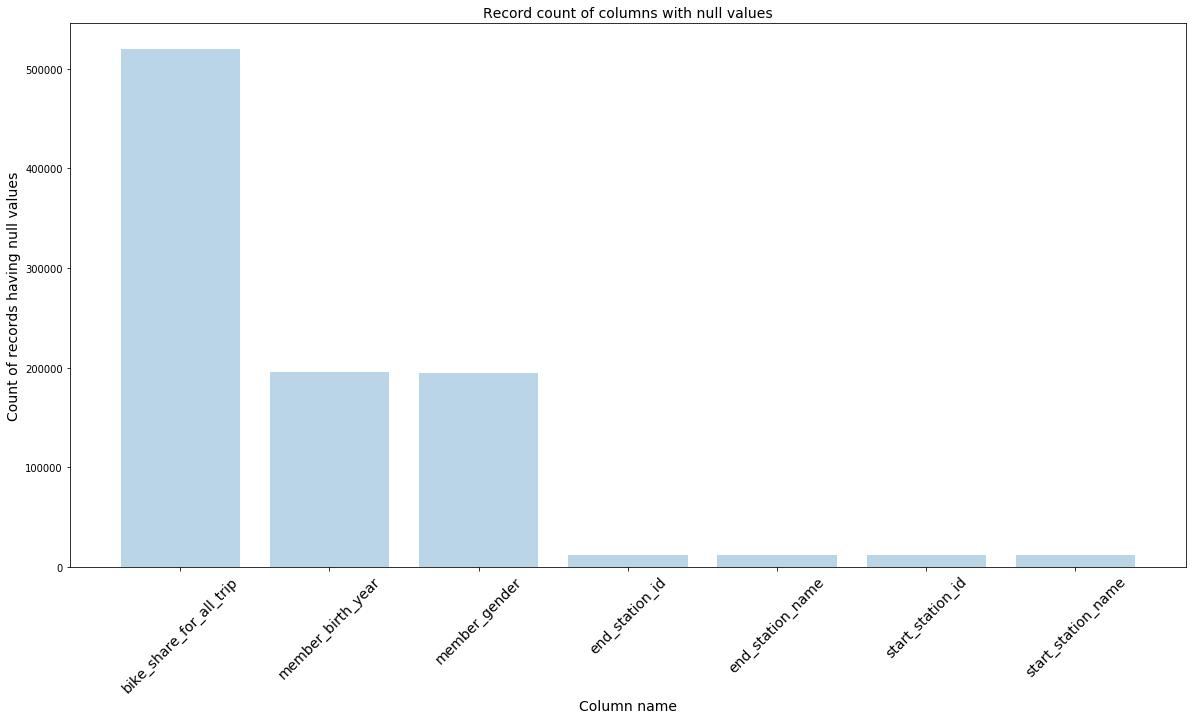

In [12]:
sorted_na_count = na_count.sort_values(by='frequency', ascending=False)
fig, ax = plt.subplots(figsize=(20,10))
ax.bar(x=sorted_na_count.column_name, height=sorted_na_count.frequency, alpha=0.3);
ax.set_ylabel("Count of records having null values", fontsize=14)
ax.set_xlabel("Column name", fontsize=14)
plt.xticks(rotation=45, fontsize=14)
ax.set_title("Record count of columns with null values", fontsize=14);

Above graph shows count of records having null values in one or more fields. Total record count in the data frame is 2758915. The one with the highest number of nulls is `bike_share_for_all_trip` which is 18% of total records. For now, I will fix some null fields while keeping some of them around.  

### Null values in start_station_id & end_station_id (action - delete records with null values) <a class="anchor" id="remove_null_station_id"></a>

In [13]:
# Delete records having null values in start_station_id or end_station_id
df.dropna(subset=['start_station_id', 'end_station_id'], axis=0, inplace=True)

### Test that above statement has cleaned up records having nulls in station ID fields

In [14]:
# Check if there is any record with start_station_id = null
len(df[pd.isnull(df.start_station_id)].index)

0

In [15]:
# Check if there is any record with end_station_id = null
len(df[pd.isnull(df.end_station_id)].index)

0

### member_birth_year is having NaN values (action - remove records with member_birth_year == NaN) <a class="anchor" id="remove_null_birth_year"></a>

In [16]:
# Delete records having null 
df.dropna(subset=['member_birth_year'], axis=0, inplace=True)

### Test that above statement has cleaned up records having nulls in `member_birth_year`

In [17]:
# Check if there is any null value in member_birth_year column
any(pd.isnull(df.member_birth_year))

False

### member_birth_year is float data type (action - convert data type to integer) <a class="anchor" id="birth_year_data_type"></a>

In [18]:
# Check if all float numbers can be converted to integer
all([x.is_integer() for x in df.member_birth_year])

True

In [19]:
df['member_birth_year'] = df.member_birth_year.apply(lambda x: int(x))

### Test that member_birth_year is of int data type

In [20]:
df.member_birth_year.dtypes

dtype('int64')

### Can data type of  `start_station_id` be integer?<a class="anchor" id="start_station_id_data_type"></a>

In [21]:
def can_be_integer(df, col):
    return all([x.is_integer() for x in df[col]])

In [22]:
# Check if start_station_id can be transformed to become integer column
can_be_integer(df, 'start_station_id')

True

### start_station_id is float data type (action - convert data type to integer)

In [23]:
df['start_station_id'] = df.start_station_id.apply(lambda x: int(x))

### Test that start_station_id is of int data type

In [24]:
df.start_station_id.dtypes

dtype('int64')

### Can data type of  `end_station_id` be integer?<a class="anchor" id="end_station_id_data_type"></a>

In [25]:
# Repeat the above step for end_station_id
can_be_integer(df, 'end_station_id')

True

### end_station_id is float data type (action - convert data type to integer)

In [26]:
df['end_station_id'] = df.end_station_id.apply(lambda x: int(x))

### Test that end_station_id is of int data type

In [27]:
df.bike_id.dtypes

dtype('int64')

### start_time & end_time are string fields (action - convert data types to datetime field)<a class="anchor" id="time_data_type"></a>

In [28]:
df.start_time = pd.to_datetime(df.start_time)
df.end_time = pd.to_datetime(df.end_time)

### Test start & end times are of datetime type

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2551789 entries, 0 to 192081
Data columns (total 16 columns):
bike_id                    int64
bike_share_for_all_trip    object
duration_sec               int64
end_station_id             int64
end_station_latitude       float64
end_station_longitude      float64
end_station_name           object
end_time                   datetime64[ns]
member_birth_year          int64
member_gender              object
start_station_id           int64
start_station_latitude     float64
start_station_longitude    float64
start_station_name         object
start_time                 datetime64[ns]
user_type                  object
dtypes: datetime64[ns](2), float64(4), int64(5), object(5)
memory usage: 331.0+ MB


### start_time & end_time are string fields (action - convert data types to datetime field)<a class="anchor" id="duration_cleanup"></a>

`duration` field is a derived field. I need to confirm that `end_time - start_time` expressed in seconds matches with value in `duration` column

In [30]:
df['computed_duration_sec'] = (df.end_time - df.start_time).astype('timedelta64[s]')

In [31]:
# Check if value in duration field matches with computed duration field
len(df.query("duration_sec != computed_duration_sec").index)

16

This is unclean data showing up as a result of the aove query. I compute `end_time - start_time` and compare this value with value in `duration` field. For 16 records, these two values don't line up.
I can notice records where end time is before start time. One example is: `bike_id = 2487 and index = 115420`.
I delete these records from the data frame.

### `duration` field value does not match with difference of end time and start time for some records

In [32]:
# Delete records with incorect duration_id
df = df[df.duration_sec == df.computed_duration_sec]

In [87]:
# save cleaned data into file
df.to_csv("./data/cleaned_df.csv", index=False)

## Data Wrangling <a class="anchor" id="data_wrangling"></a>

In [33]:
"""
Calculate distance between start and end points
"""
def calculate_distance (row):
    start = Point(row['start_station_latitude'], row['start_station_longitude'])
    stop = Point(row['end_station_latitude'], row['end_station_longitude'])
    return distance.distance(start, stop).miles

### Derived fields <a class="anchor" id="derived_fields"></a>

In [34]:
# Add date based fields to data frame for ease of analysis
df['end_time_year_month'] = df.end_time.apply(lambda x: x.strftime("%Y-%m"))
df['end_time_year'] = df.end_time.apply(lambda x: x.strftime("%Y"))
df['end_time_month'] = df.end_time.apply(lambda x: x.strftime("%m"))
df['end_time_day'] = df.end_time.apply(lambda x: x.strftime("%d"))
df['end_time_hour'] = df.end_time.apply(lambda x: x.strftime("%H"))
df['end_date'] = df.end_time.apply(lambda x: x.strftime('%Y-%m-%d')) 
df['day_of_week'] = df.end_time.dt.day_name()
# Compute member's age using DOB
df['member_age'] = pd.to_numeric(df['end_time_year']) - df['member_birth_year']
# Compute distance traveled in miles
df['distance_in_mile'] = df.apply(lambda row: calculate_distance(row), axis=1)

In [35]:
df.head()

,bike_id,bike_share_for_all_trip,duration_sec,end_station_id,end_station_latitude,end_station_longitude,end_station_name,end_time,member_birth_year,member_gender,...,computed_duration_sec,end_time_year_month,end_time_year,end_time_month,end_time_day,end_time_hour,end_date,day_of_week,member_age,distance_in_mile
0,4902,No,52185,13,37.794231,-122.402923,Commercial St at Montgomery St,2019-03-01 08:01:55.975,1984,Male,...,52185.0,2019-03,2019,03,01,08,2019-03-01,Friday,35,0.338015
2,5905,No,61854,3,37.786375,-122.404904,Powell St BART Station (Market St at 4th St),2019-03-01 05:24:08.146,1972,Male,...,61854.0,2019-03,2019,03,01,05,2019-03-01,Friday,47,1.681051
3,6638,No,36490,70,37.773311,-122.444293,Central Ave at Fell St,2019-03-01 04:02:36.842,1989,Other,...,36490.0,2019-03,2019,03,01,04,2019-03-01,Friday,30,0.162113
4,4898,Yes,1585,222,37.792714,-122.248780,10th Ave at E 15th St,2019-03-01 00:20:44.074,1974,Male,...,1585.0,2019-03,2019,03,01,00,2019-03-01,Friday,45,1.498758
5,5200,No,1793,323,37.798014,-122.405950,Broadway at Kearny,2019-03-01 00:19:51.760,1959,Male,...,1793.0,2019-03,2019,03,01,00,2019-03-01,Friday,60,2.068083


In [36]:
# Checking distrbution of member age
df.member_age.describe()

count    2.551773e+06
mean     3.517633e+01
std      1.043761e+01
min      1.800000e+01
25%      2.800000e+01
50%      3.300000e+01
75%      4.100000e+01
max      1.410000e+02
Name: member_age, dtype: float64

Data above shows that the median age is 33 years. But there are member who are 141 years. That seems like  data collection error. I would like to eliminate these outliers. I will generate a histogram and box plot for better visualization.

### Handling outliers <a class="anchor" id="handling_outliers"></a>

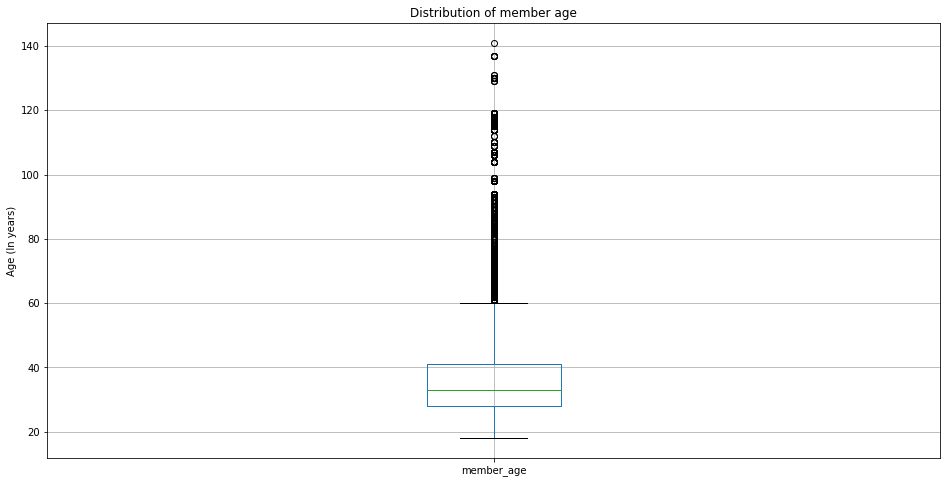

In [37]:
fig, ax = plt.subplots(figsize=(16,8))
df[['member_age']].boxplot();
ax.set_ylabel('Age (In years)')
ax.set_title('Distribution of member age');


In [38]:
df['member_age'].describe(np.arange(.05, 1.05, .05))

count    2.551773e+06
mean     3.517633e+01
std      1.043761e+01
min      1.800000e+01
5%       2.200000e+01
10%      2.400000e+01
15.0%    2.500000e+01
20%      2.700000e+01
25%      2.800000e+01
30%      2.900000e+01
35%      3.000000e+01
40%      3.100000e+01
45%      3.200000e+01
50%      3.300000e+01
55.0%    3.400000e+01
60.0%    3.500000e+01
65.0%    3.700000e+01
70%      3.800000e+01
75.0%    4.100000e+01
80%      4.300000e+01
85.0%    4.600000e+01
90.0%    5.000000e+01
95%      5.600000e+01
100%     1.410000e+02
max      1.410000e+02
Name: member_age, dtype: float64

If I filter out all records with `member_age` <= 60 then that corresponds to more than 95 percentile.

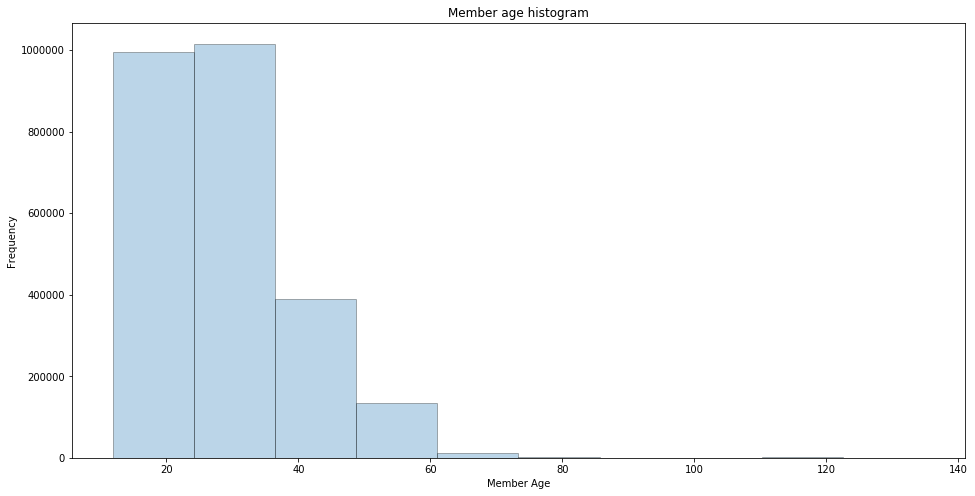

In [39]:
fig, ax = plt.subplots(figsize=(16,8))
plt.hist(
    x=df.member_age, 
    alpha=0.3, 
    align='left', 
    ec='black', 
);
plt.xlabel('Member Age')
plt.ylabel('Frequency')
plt.title('Member age histogram');

Box plot shows outliers from age 60 years and beyond.  I will delete all the records with age > 60 so that the outliers don't influence the analysis.

In [40]:
print("Count of records with member age > 60 is %d" % len(df[df.member_age > 60].index.tolist()))

Count of records with member age > 60 is 55745


### More cleaning<a class="anchor" id="more_cleaning"></a>

### Delete records with member age > 60

In [41]:
df = df.query("member_age <= 60")

### Test that data frame has no record with member age > 60

In [42]:
print("Count of records with member age > 60 is %d" % len(df[df.member_age > 60].index.tolist()))

Count of records with member age > 60 is 0


In [43]:
"""
Bucketize age - default bucket width is 10 years
"""
def bucket_age(age, width=10):
    d = age // width
    low_bound = (age // width) * width
    high_bound = ((age // width) + 1) * width
    return "%.2d - %.2d" % (low_bound, high_bound)

In [44]:
df['member_age_bracket'] = df.member_age.apply(lambda x: bucket_age(x, 5))

## Exploratory Analysis<a class="anchor" id="exploratory_analysis"></a>

Looking at this bike rental data there are several questions that come to my mind.

* What is the gender profile of the bike users?
* Does this profile change between subscribers and customers?
* Is there a specific age group which have more daily bike rentals compared to other age groups in the same gender category? 
* As we have data spanning over few years, I am interested in finding out, how the bike rental business is doing over years. To measure the success of the company, I plan to compute few metrics and track them in time series. The metrics are:
    * Number of bike rentals per period
    * Distance in miles
    * Duration of the rides
    * Count of bikes
    

### Who are using the bike rental?<a class="anchor" id="who_are_bike_renters"></a>

* 74% of the total bike rentals are done by men
* 24% by females. Gender ratio between male and female is approximately 3:1. 
* There a small percentage that belongs to other category but we can ignore it for analysis purposes.

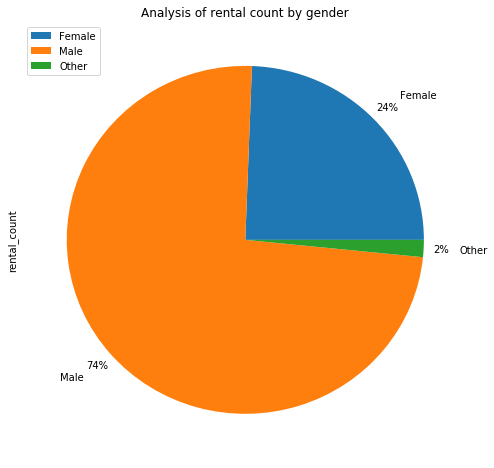

In [45]:
ax = \
df[['bike_id', 'member_gender']]\
.groupby('member_gender')\
.agg({'bike_id': 'count'})\
.reset_index()\
.rename(columns={'bike_id': 'rental_count'})\
.set_index('member_gender')\
.plot.pie(y='rental_count', 
          autopct='%1.0f%%', 
          pctdistance=1.1, 
          labeldistance=1.2,
          figsize=(8, 8));

ax.set_title('Analysis of rental count by gender');


Next I would like to see age distribution among these two gender to get clarity on the demographics of the users.

### Which age category do they belong to?<a class="anchor" id="age_category"></a>

* Median age of female biker = 32
* Median age of male biker = 33

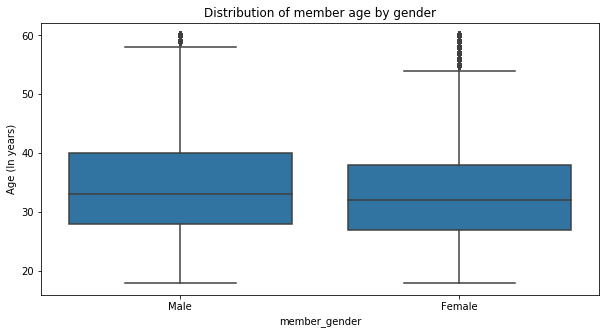

In [46]:
gender_age_df = df.query("member_gender == 'Female' or member_gender == 'Male'")\
[['bike_id', 'member_gender', 'member_age', 'user_type', 'duration_sec', 'distance_in_mile']]
gender_age_df['duration_min'] = gender_age_df.duration_sec / 60
fig, ax = plt.subplots(figsize=(10,5))
color = sns.color_palette()

ax = sns.boxplot(x="member_gender", y="member_age", data=gender_age_df, color=color[0])
ax.set_ylabel('Age (In years)')
ax.set_title('Distribution of member age by gender');


In [47]:
df.query("member_gender == 'Female'")['member_age'].describe()

count    609211.000000
mean         33.473251
std           8.846677
min          18.000000
25%          27.000000
50%          32.000000
75%          38.000000
max          60.000000
Name: member_age, dtype: float64

df.query("member_gender == 'Male'")['member_age'].describe()

In [48]:
print("Median age of female biker = %0.0f" % df.query("member_gender == 'Female'")['member_age'].median())
print("Median age of male biker = %0.0f" % df.query("member_gender == 'Male'")['member_age'].median())


Median age of female biker = 32
Median age of male biker = 33


To expand the same analysis to user type - customers & subscribers, I will use box plot using facet grid.

### Age profile of subscribers & customers<a class="anchor" id="age_profile_user_type"></a>

Non-subscribers are relatively younger people. Subscribers have higher median age as well and higher 25 & 75 percentile values compared to non-subscribers (customers). This observation holds good for both genders.

Median age of female and male subscribers are 32 & 33 years respectievly compared to 30 & 31 for same gender category in customers.

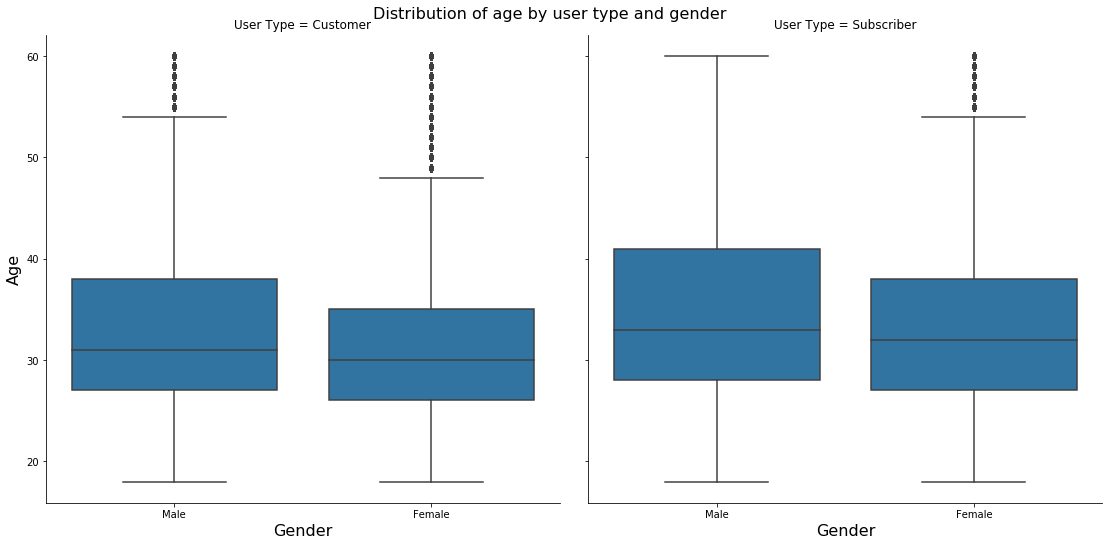

In [49]:
g = sns.catplot(
    x="member_gender", 
    y="member_age", 
    col="user_type", 
    data=gender_age_df, 
    kind="box", 
    color = sns.color_palette()[0]
)
plt.gcf().set_size_inches(16, 8)
plt.suptitle('Distribution of age by user type and gender', size=16)
g.axes[0][0].set_ylabel('Age', size=16)
g.axes[0][0].set_xlabel('Gender', size=16)
g.axes[0][1].set_xlabel('Gender', size=16)
g.axes[0][0].set_title('User Type = Customer', size=12)
g.axes[0][1].set_title('User Type = Subscriber', size=12);


In [50]:
gender_age_df[['member_gender', 'user_type', 'member_age']]\
.groupby(['member_gender', 'user_type'])\
.agg({'member_age' : 'median'})\
.reset_index()

,member_gender,user_type,member_age
0,Female,Customer,30
1,Female,Subscriber,32
2,Male,Customer,31
3,Male,Subscriber,33


### Business metrics<a class="anchor" id="business_metrics"></a>
Now I try to compute some metrics outlining the performance of the bike renatl company. The metrics that I focus on are:

    * Number of bike rentals per period
    * Distance in miles
    * Duration of the rides
    * Duration of bike ride

In [51]:
# Compute summary metric values
print("Total number of bike rentals = %d" % len(df.index))
print("Total distance covered by %d bike rides = %.2f miles" % (len(df.index), df.distance_in_mile.sum()))
print("Total rental duration = %d hours" % (df.duration_sec.sum() / (60 * 60)))
print("Average distance per ride = %0.4f miles" % (df.distance_in_mile.sum() / float(len(df.index))))
print("Average distance per hour = %0.4f miles" % \
      (df.distance_in_mile.sum() / float((df.duration_sec.sum() / (60 * 60)))))


Total number of bike rentals = 2496028
Total distance covered by 2496028 bike rides = 2503015.28 miles
Total rental duration = 536370 hours
Average distance per ride = 1.0028 miles
Average distance per hour = 4.6666 miles


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2496028 entries, 0 to 192081
Data columns (total 27 columns):
bike_id                    int64
bike_share_for_all_trip    object
duration_sec               int64
end_station_id             int64
end_station_latitude       float64
end_station_longitude      float64
end_station_name           object
end_time                   datetime64[ns]
member_birth_year          int64
member_gender              object
start_station_id           int64
start_station_latitude     float64
start_station_longitude    float64
start_station_name         object
start_time                 datetime64[ns]
user_type                  object
computed_duration_sec      float64
end_time_year_month        object
end_time_year              object
end_time_month             object
end_time_day               object
end_time_hour              object
end_date                   object
day_of_week                object
member_age                 int64
distance_in_mile       

In [99]:
gender_user_agg_df = \
gender_age_df.query("member_gender == 'Male' or member_gender == 'Female'")[['duration_min', 'distance_in_mile', 'bike_id', 'user_type', 'member_gender']]\
.groupby(['user_type', 'member_gender'])\
.agg({'bike_id': 'count', 'duration_min': {'mean', 'median'}, 'distance_in_mile': {'mean', 'median'}})\
.reset_index()\
.rename(columns={'bike_id': 'rental_count'})

gender_user_agg_df.columns = gender_user_agg_df.columns.droplevel(1)
gender_user_agg_df.columns = ['user_type', 'member_gender', 'rental_count', 'median_duration_min', \
                              'mean_duration_min', 'median_distance_mile', 'mean_distance_mile']

gender_user_agg_df


,user_type,member_gender,rental_count,median_duration_min,mean_duration_min,median_distance_mile,mean_distance_mile
0,Customer,Female,86666,16.433333,30.456360,0.986309,1.099585
1,Customer,Male,186572,13.716667,25.234892,0.980472,1.101624
2,Subscriber,Female,522545,9.616667,12.427745,0.883565,1.041147
3,Subscriber,Male,1660569,8.250000,10.690110,0.847403,0.973448


In [95]:
gender_age_df.query('user_type == "Customer" and member_gender == "Female"')[['duration_min']].mean()

duration_min    30.45636
dtype: float64

### Who rides more - subscribers or customers?<a class="anchor" id="user_type_ride"></a>

* Median distance traveled is more for non-subscribers
* Non-subscribers also have higher median value for bike ride duration.

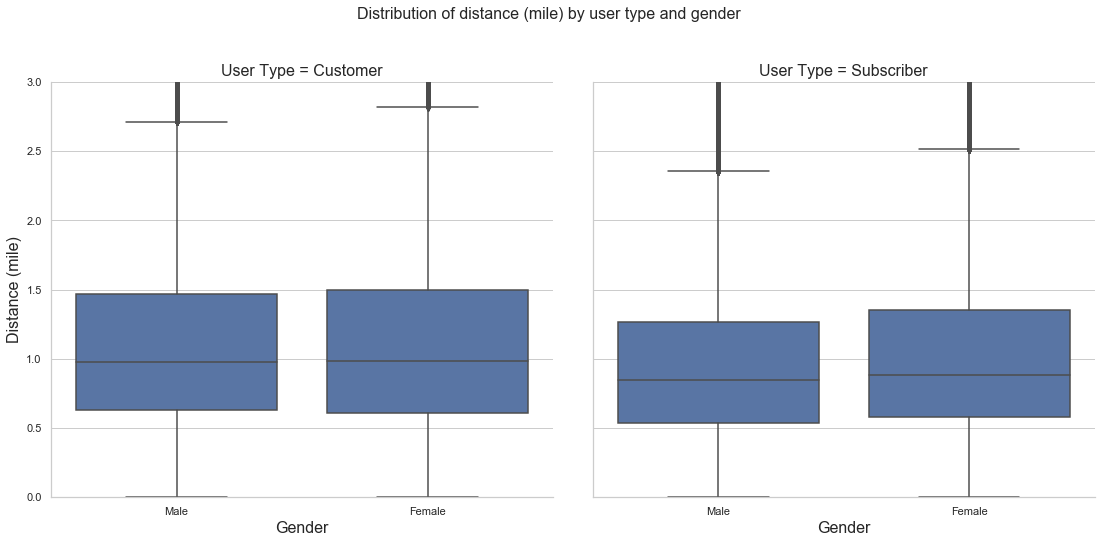

In [89]:
g = sns.catplot(
    x="member_gender", 
    y="distance_in_mile", 
    col="user_type", 
    data=gender_age_df, 
    kind="box", 
    color = sns.color_palette()[0]
)
plt.gcf().set_size_inches(16, 8)
plt.subplots_adjust(top=0.85)
plt.suptitle('Distribution of distance (mile) by user type and gender', size=16)
g.axes[0][0].set_ylabel('Distance (mile)', size=16)
g.axes[0][0].set_xlabel('Gender', size=16)
g.axes[0][0].set_ylim(bottom=0,top=3)
g.axes[0][1].set_xlabel('Gender', size=16)
g.axes[0][1].set_ylim(bottom=0,top=3)
g.axes[0][0].set_title('User Type = Customer', size=16)
g.axes[0][1].set_title('User Type = Subscriber', size=16);

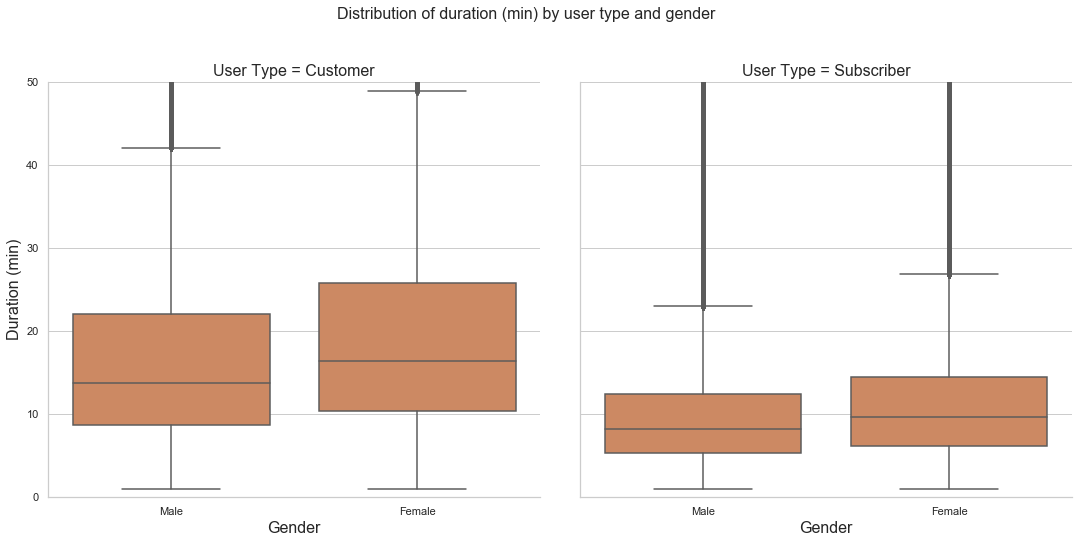

In [90]:
g = sns.catplot(
    x="member_gender", 
    y="duration_min", 
    col="user_type", 
    data=gender_age_df, 
    kind="box", 
    color = sns.color_palette()[1]
)
plt.gcf().set_size_inches(16, 8)
plt.suptitle('Distribution of duration (min) by user type and gender', size=16)
plt.subplots_adjust(top=0.85)
g.axes[0][0].set_ylabel('Duration (min)', size=16)
g.axes[0][0].set_xlabel('Gender', size=16)
g.axes[0][0].set_ylim(bottom=0,top=50)
g.axes[0][1].set_xlabel('Gender', size=16)
g.axes[0][1].set_ylim(bottom=0,top=50)
g.axes[0][0].set_title('User Type = Customer', size=16)
g.axes[0][1].set_title('User Type = Subscriber', size=16);

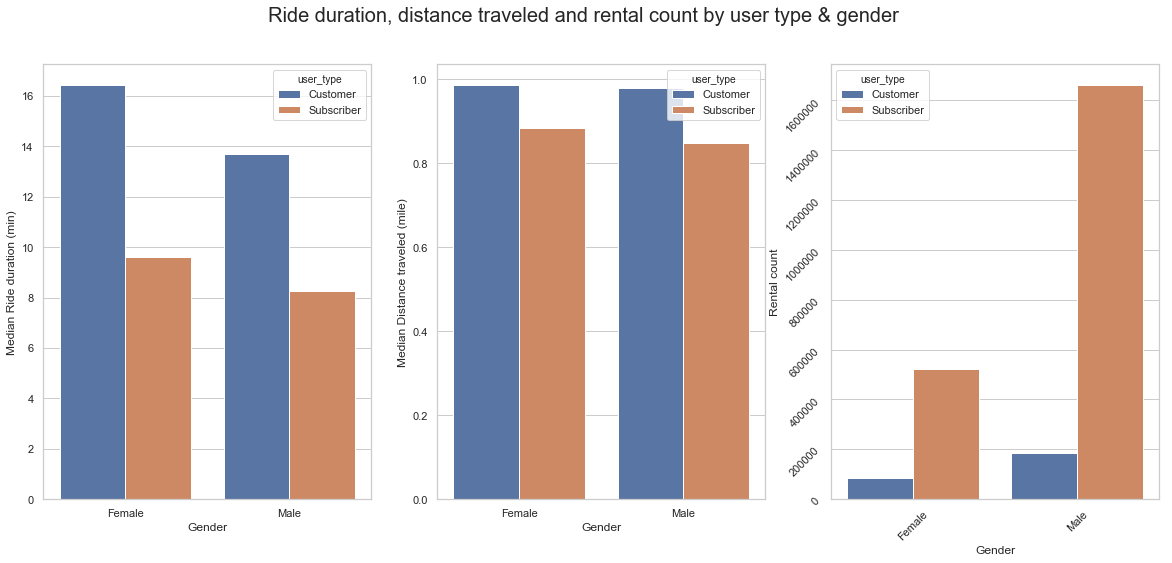

In [100]:
# Visualization of monthly metrics
fig, ax = plt.subplots(1, 3, figsize=(20,8),sharex=True)
fig.suptitle('Ride duration, distance traveled and rental count by user type & gender', fontsize=20)

metrics = ['median_duration_min','median_distance_mile', 'rental_count']
for i,j in enumerate(range(len(ax))):
    g = sns.catplot(x="member_gender", y=metrics[i], hue="user_type", data=gender_user_agg_df, kind="bar", ax=ax[j])    

y_labels = ['Median Ride duration (min)', 'Median Distance traveled (mile)', 'Rental count']
for i in range(len(ax)):
    ax[i].set_ylabel('%s' % y_labels[i], fontsize=12)
    ax[i].set_xlabel('Gender', fontsize=12)
    if (i == len(ax) - 1):
        ax[i].tick_params(labelrotation=45)

# Hack to eliminate empty grids at the end
for i in range(2,5):
    plt.close(i)
    



On the average, customers tend to travel more miles per ride compared to subscribers. Their average duration is also higher compared to subscribers.

Number of rental count for subscribers is several times higher than occasional customers. This seems logical as subscribers pay monthly fee to get that service and they may wish maximize the benefit of paid subscription.

In [57]:
# Compute monthly metrics - cumulative rental count, cumulative distance & cumulative usage in hours
monthly_metric_df = \
df.query('end_time_year_month < "2019-03"')[['end_time_year_month', 'bike_id', 'duration_sec', 'distance_in_mile']]\
.groupby(['end_time_year_month'])\
.agg({'bike_id': ['count', lambda x: x.nunique()], 'duration_sec': 'sum', 'distance_in_mile': 'sum'})\
.reset_index()

monthly_metric_df.columns = monthly_metric_df.columns.droplevel(1)

monthly_metric_df.columns = ['end_time_year_month', 'rental_count', 'bike_count', 'duration_sec', 'distance_in_mile']

monthly_metric_df['cumulative_rental_count'] = monthly_metric_df.rental_count.transform(np.cumsum)
monthly_metric_df['cumulative_distance_in_mile'] = monthly_metric_df.distance_in_mile.transform(np.cumsum)
monthly_metric_df['cumulative_duration_hours'] = (monthly_metric_df.duration_sec.transform(np.cumsum) / (60 * 60))


### How is the business doing in past few years?<a class="anchor" id="business_performance"></a>

All three cumulative values show steady upward trend with almost equal slope indicating growth of business. Careful look reveals that there is growth spurt from April 2018 till October 2018 showing relatively higher growth rate compared to same period in previous year. After October 2018, rental business shows signs of slow down. 


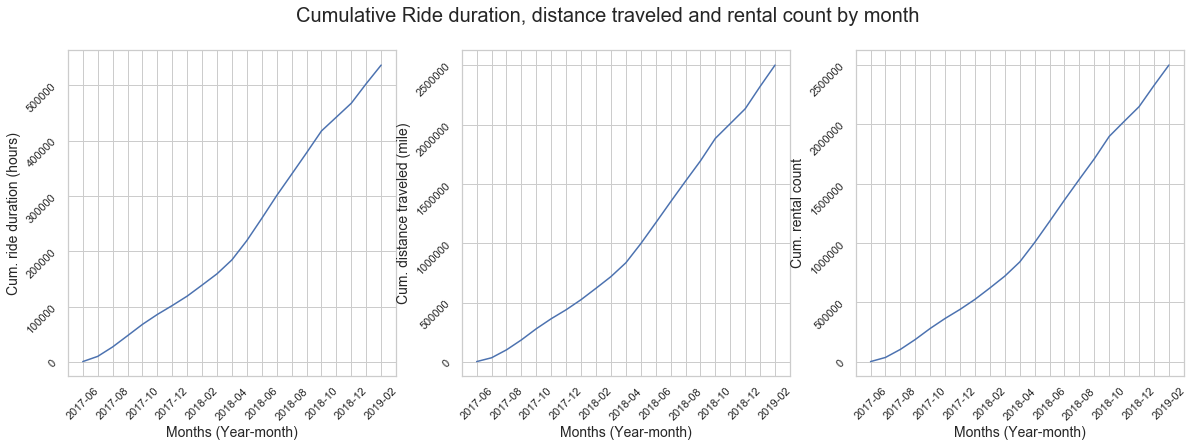

In [101]:
# Visualization of monthly metrics
fig, ax = plt.subplots(1, 3, figsize=(20,6),sharex=True)
fig.suptitle('Cumulative Ride duration, distance traveled and rental count by month', fontsize=20)

metrics = ['cumulative_duration_hours','cumulative_distance_in_mile', 'cumulative_rental_count']
for i,j in enumerate(range(len(ax))):
    sns.set(style="whitegrid")
    g = sns.lineplot(x="end_time_year_month", y=metrics[i], data=monthly_metric_df, ax=ax[j])    

y_labels = ['Cum. ride duration (hours)', 'Cum. distance traveled (mile)', 'Cum. rental count']

xtick_labels = [x if index % 2 == 0 else '' for index, x in enumerate(monthly_metric_df.end_time_year_month.unique().tolist())]
for i in range(len(ax)):
    ax[i].tick_params(labelrotation=45)
    ax[i].set_xticklabels(xtick_labels)
    ax[i].set_ylabel('%s' % y_labels[i], fontsize=14)
    ax[i].set_xlabel('Months (Year-month)', fontsize=14)


# Hack to eliminate empty grids at the end
for i in range(2,5):
    plt.close(i)

### Does rental volume show seasonality?<a class="anchor" id="rental_volume_seasonality"></a>

* Bike rental volume goes down during winter season which is also the season when it rains.
* Dip in monthly volume can be observer in Nov_dec 2017 and again getting repeated in 2018

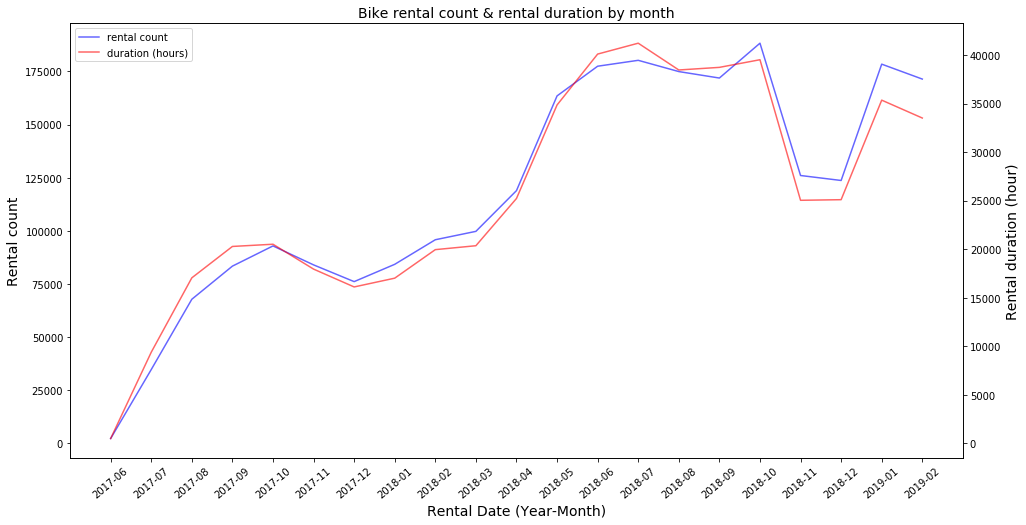

In [59]:
# Line graph visualization for monthly bike rental count and biked duration plotted in dual-axis graph
fig, ax = plt.subplots(figsize=(16,8))

line1 = ax.plot(monthly_metric_df.end_time_year_month, monthly_metric_df.rental_count, alpha=0.6, c='b')

ax.set_xticklabels([x for x in monthly_metric_df.end_time_year_month], rotation=40)
ax.set_title('Bike rental count & rental duration by month', fontsize=14)
ax.set_xlabel('Rental Date (Year-Month)', fontsize=14)
ax.set_ylabel('Rental count',fontsize=14) 

ax2 = ax.twinx()
line2 = ax2.plot(monthly_metric_df.end_time_year_month, monthly_metric_df.duration_sec / (60 * 60), c='r', alpha=0.6)
ax2.set_ylabel('Rental duration (hour)',fontsize=14);
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1 + h2, ['rental count', 'duration (hours)'], loc=2);

Month-wise rental volume broken down by gender follows.

In [60]:
gender_agg_df = df[['end_time_year_month', 'member_gender', 'bike_id']]\
.groupby(['member_gender', 'end_time_year_month'], as_index=False)\
.agg({'bike_id': 'count'})\
.rename(columns={'bike_id': 'rental_count'})\
.pivot(index='end_time_year_month', columns='member_gender', values='rental_count')\
.reset_index()

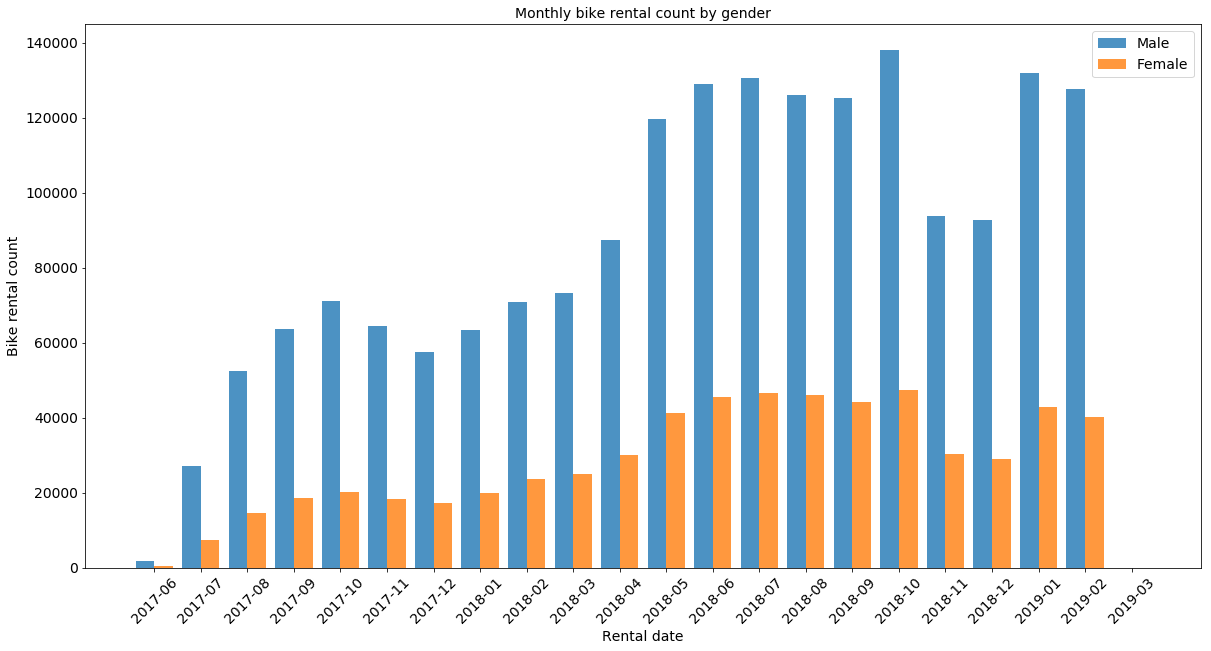

In [61]:
fig, ax = plt.subplots(figsize=(20,10))
width = 0.40
ind = np.arange(len(gender_agg_df.index.tolist()))
plt.bar(
    ind,
    gender_agg_df.Male,
    alpha=0.8, 
    width=width
);
plt.bar(
    ind + width,
    gender_agg_df.Female,
    alpha=0.8, 
    width=width
);
plt.legend(['Male', 'Female'], fontsize=14)
plt.xticks(ind + width / 2.0, gender_agg_df.end_time_year_month.tolist(), rotation=45, fontsize=14);
plt.yticks(fontsize=14)
plt.ylabel('Bike rental count', fontsize=14)
plt.xlabel('Rental date', fontsize=14);
plt.title('Monthly bike rental count by gender', fontsize=14);

### Business Growth<a class="anchor" id="business_growth"></a>

Bike rental and rental duration plotted against months follow each other closely. 

The dual axis line graph shows growth of business in successive months during summer. Rental volume and biked duration decreases during winter months - Oct through January. This seasonal pattern can be observed in 2017 as well as in 2018. 

Though the rental business slowed down in colder months, like October 2018, the business registers almost 50% increase in bike rental compared to same month in 2017. So instead of just time series analysis, I plan to compare with same months from previous year after getting them side-by-side.

In [62]:
# Compute rental number and get last year's metric value for same month in one record
from dateutil.relativedelta import relativedelta
seasonal_df = \
df.query('end_time_year_month < "2019-03"')[['end_time_year_month', 'bike_id']]\
.groupby(['end_time_year_month'])\
.agg({'bike_id': 'count'})\
.reset_index()\
.rename(columns={'bike_id': 'rental_count'})
seasonal_df['prev_year_month'] = seasonal_df.end_time_year_month\
.apply(lambda x: (datetime.strptime(x, '%Y-%m') + relativedelta(years=-1)).strftime('%Y-%m'))

seasonal_df = pd.merge(seasonal_df[['end_time_year_month', 'rental_count']], seasonal_df, left_on='end_time_year_month', right_on='prev_year_month')\
.sort_index()[['end_time_year_month_y', 'rental_count_x', 'rental_count_y']]\


seasonal_df.columns = ['year_month', 'ly_same_month_rental_count', 'rental_count']
seasonal_df['pct_increase'] = seasonal_df\
.apply(lambda row: int((row['rental_count'] - row['ly_same_month_rental_count']) * 100 / row['ly_same_month_rental_count']), axis=1)



Number of rentals per month is compared with same month in previous year. For example October 2018 is compared in October 2017. Percent increase of the metric value from same month in previous year is used as basis and posted as annotation. 

Though business slows down during winter months, rental volume increased by 50-60% during the period. For summer months, business grew by more than 100%.

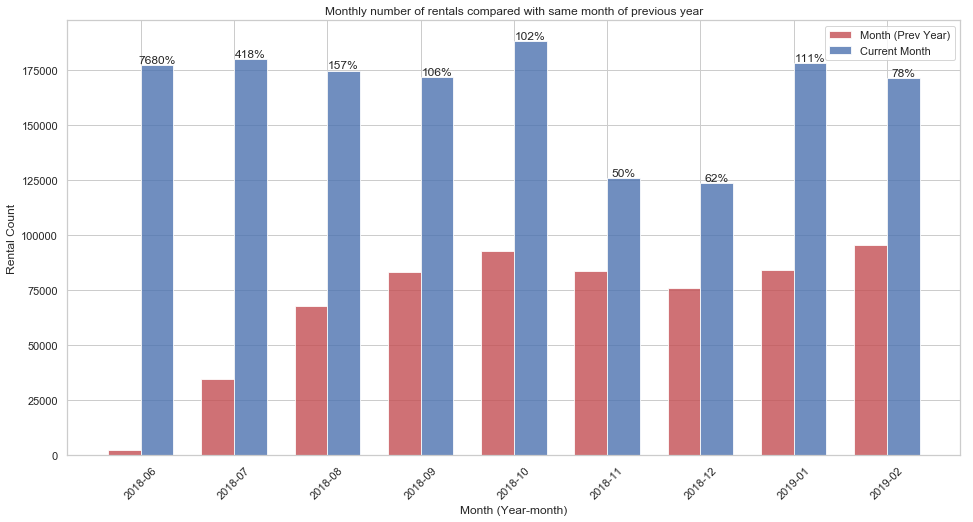

In [102]:
# Visualization of monthly rental volume compared to data from same month last year
fig, ax = plt.subplots(figsize=(16,8))
width = 0.35
ind = np.arange(len(seasonal_df.year_month.tolist()))
plt.bar(
    ind,
    seasonal_df.ly_same_month_rental_count,
    alpha=0.8, 
    color='r',
    width=width
);
ax2 = plt.bar(
    ind + width,
    seasonal_df.rental_count,
    alpha=0.8, 
    color='b',
    width=width
);

labels = map(lambda x: str(x) + '%', seasonal_df.pct_increase.tolist())

plt.legend(['Month (Prev Year)', 'Current Month'])
plt.xticks(ind + width / 2.0, seasonal_df.year_month.tolist(), rotation=45);

plt.ylabel('Rental Count')
plt.xlabel('Month (Year-month)')
plt.title('Monthly number of rentals compared with same month of previous year');

for rect, label in zip(ax2.patches, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')

### Which age group is using bike rental more?<a class="anchor" id="business_growth_age_group"></a>

Overall bike rental business steady growth over time exhibited by cumulative having upward slope in time series graph. Monthly metrics compared to same month pervious year also show 50-100% growth in rental volume. 

Next I analyze this growth in different age brackets in gender categories.

In [64]:
# Aggregate cumulative rental volume by gender and age range
agg_df = df.query('end_time_year_month <= "2019-03"')[['member_gender', 'member_age_bracket', 'bike_id', 'end_time_year_month']]\
.groupby(['member_gender', 'member_age_bracket', 'end_time_year_month'])\
.agg({'bike_id': 'count'})\
.rename(columns={'bike_id': 'rental_count'})

agg_df['cumulative_rental_count'] = \
agg_df.groupby(['member_gender', 'member_age_bracket']).rental_count.transform(np.cumsum)
agg_df.reset_index(inplace=True)
agg_df = agg_df.query("end_time_year_month >= '2017-07' and end_time_year_month < '2019-03'")


* 25 - 30 & 30- 35 are fastest growing age brackets in both gender who are increasingly using bike rental
* For male members, 30-35 age bracket has significantly outperformed 25-30 age bracket
* For female members, 25-30 and 30-35 age groups are competing very closely.
* 25-30 female age group surpasses 30-35 in bike usage around October 2018 and maintained the lead till March 2019.

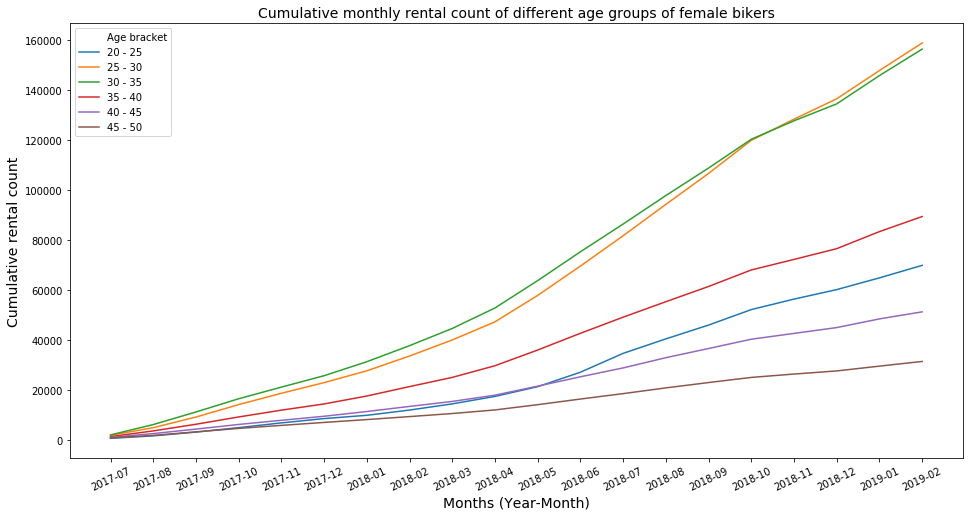

In [65]:
# Plot cumulative rental count for female bikers upto age bracket 45 - 50 years
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(data=agg_df.query("member_gender == 'Female' and member_age_bracket >= '20 - 25' and member_age_bracket <= '45 - 50'"), 
             x='end_time_year_month', 
             y='cumulative_rental_count', 
             hue='member_age_bracket', 
             estimator=None);
ax.set_ylabel('Cumulative rental count', fontsize=14)
ax.set_xlabel('Months (Year-Month)', fontsize=14)
plt.xticks(rotation=25)
ax.set_title('Cumulative monthly rental count of different age groups of female bikers', fontsize=14);
plt.legend().get_texts()[0].set_text("Age bracket")



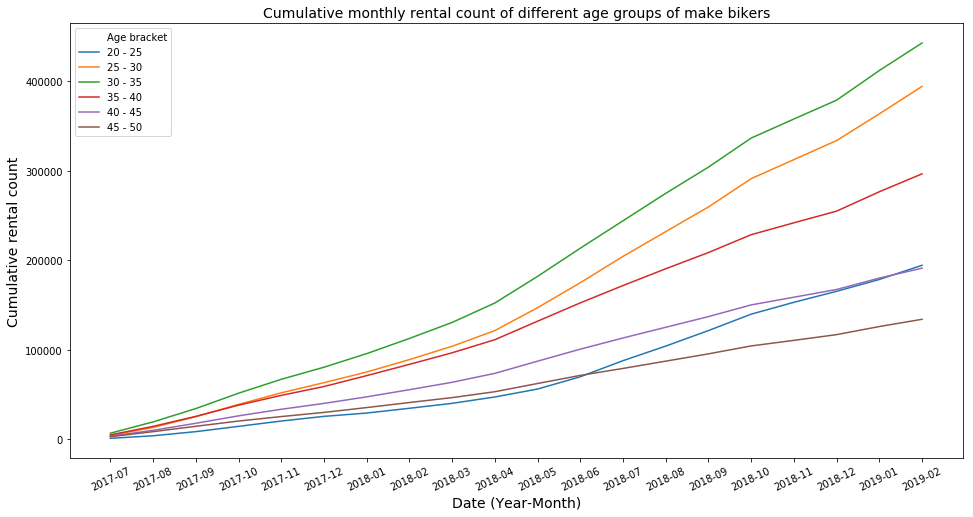

In [66]:
# Plot cumulative rental count for male bikers
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(data=agg_df.query("member_gender == 'Male' and member_age_bracket >= '20 - 25' and member_age_bracket <= '45 - 50'"), 
             x='end_time_year_month', 
             y='cumulative_rental_count', 
             hue='member_age_bracket', 
             estimator=None);
ax.set_ylabel('Cumulative rental count', fontsize=14)
ax.set_title('Cumulative monthly rental count of different age groups of make bikers', fontsize=14)
plt.xticks(rotation=25)
ax.legend()
ax.set_xlabel('Date (Year-Month)', fontsize=14)
plt.legend().get_texts()[0].set_text("Age bracket")
    

### Which age group is using bike rental more?<a class="anchor" id="business_growth_age_group"></a>

In [67]:
# Aggregate bike rental number by day of week
day_agg_df = \
df.groupby(['day_of_week']).agg({'bike_id': 'count'}).reset_index().rename(columns={'bike_id': 'rental_count'})
day_agg_df['total_rental_count'] = day_agg_df.rental_count.sum()
day_agg_df['pct_of_total'] = round(day_agg_df.rental_count * 100 / day_agg_df.total_rental_count, 2)

cat_type = CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
day_agg_df['day_of_week'] = day_agg_df['day_of_week'].astype(cat_type)
# Sort dataframe based on days of the week (categorical variable)
day_agg_df = day_agg_df.sort_values(by=['day_of_week'])

Bike rental business shows periodicity with respect to day of week. Number of rentals are lowest over the weekend - Saturday & Sunday. Monday & Friday are relatively low volume days compared to middle of the week. This brings an interest guess about the purpose of bike rental - whether the main usage is  - pleasure or business use? The fact that the volume of business goes down drastically over the weekend and peaks up steam during middle of the week is indicative that the prime usage is for commuting to office. 

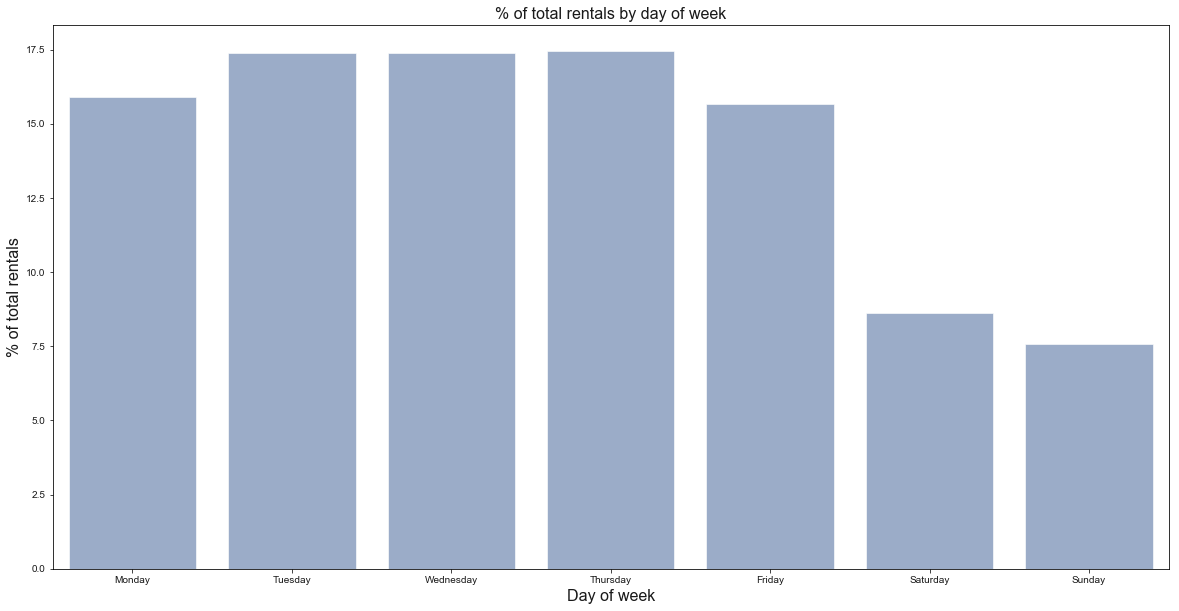

In [68]:
plt.subplots(figsize=(20,10))
sns.set(style="whitegrid")
g = sns.barplot(x="day_of_week", 
                 y="pct_of_total", 
                 data=day_agg_df, 
                 color=sns.color_palette()[0], 
                 alpha = 0.6)
g.set_xlabel('Day of week', fontsize=16)
g.set_ylabel('% of total rentals', fontsize=16)
g.set_title('% of total rentals by day of week', fontsize=16);

It may worth introducing `user_type` dimension to explore the rental pattern of two groups of bike rental consumers - subscribers & customers (occasional users) 

### Rental volume by user type and day of week<a class="anchor" id="rental_volume_user_type"></a>

In [69]:
# Aggregate bike rental number by day of week

def agg_rental_count_by_user_type(row):
    return day_agg_df.query("user_type == '%s'" % row['user_type'])[['rental_count']].sum()

day_agg_df = \
df.groupby(['day_of_week', 'user_type']).agg({'bike_id': 'count'}).reset_index().rename(columns={'bike_id': 'rental_count'})
day_agg_df['total_rental_count'] = day_agg_df.apply(lambda row: agg_rental_count_by_user_type(row), axis=1)
day_agg_df['pct_of_total'] = round(day_agg_df.rental_count * 100 / day_agg_df.total_rental_count, 2)

cat_type = CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
day_agg_df['day_of_week'] = day_agg_df['day_of_week'].astype(cat_type)
# Sort dataframe based on days of the week (categorical variable)
day_agg_df = day_agg_df.sort_values(by=['day_of_week'])

Rental behavior of `customers` is different from that of `subscribers`. Rental % of that group of bike renters show rental volume increasing during the weekend. One hypothesis is - this group rent the bike primarily for leisure usage.

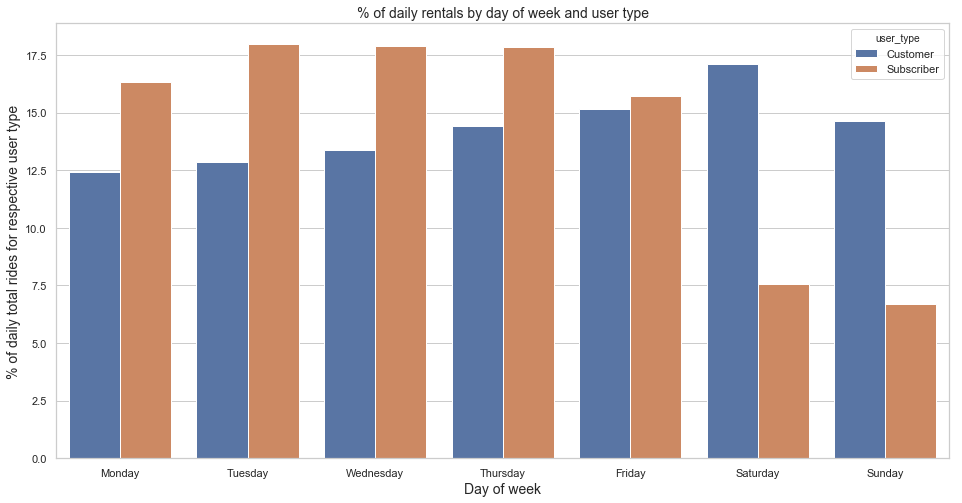

In [70]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.set(style="whitegrid")
g = sns.catplot(
    x="day_of_week", 
    y="pct_of_total", 
    hue="user_type", 
    data=day_agg_df, 
    kind="bar",
    ax=ax)
ax.set_xlabel('Day of week', fontsize=14)
ax.set_ylabel('% of daily total rides for respective user type', fontsize=14)
ax.set_title('% of daily rentals by day of week and user type', fontsize=14);
plt.close(2)



Let us introduce `month` as a dimesnsion to the above analysis to see if the rental pattern for `customers` and `subscribers` hold good.

In [71]:
def agg_by_user_type_month(x, y):
    return day_agg_df.query("user_type == '%s' and end_time_year_month == '%s'" % (x,y))['rental_count'].sum()

# Aggregate bike rental number by day of week, user_type and month
day_agg_df = \
df.query("end_time_year_month >= '2018-01' and end_time_year_month <= '2018-12'").\
groupby(['day_of_week', 'user_type', 'end_time_year_month']).agg({'bike_id': 'count'})\
.reset_index()\
.rename(columns={'bike_id': 'rental_count'})

day_agg_df['monthly_rental_count_utype'] = \
day_agg_df.apply(lambda row: agg_by_user_type_month(row['user_type'], row['end_time_year_month']), axis=1)

day_agg_df['pct_of_total'] = day_agg_df.rental_count * 100 / day_agg_df.monthly_rental_count_utype
day_agg_df.pct_of_total = day_agg_df.pct_of_total.astype(int)

cat_type = CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
day_agg_df['day_of_week'] = day_agg_df['day_of_week'].astype(cat_type)
# Sort dataframe based on days of the week (categorical variable)
day_agg_df = day_agg_df.sort_values(by=['end_time_year_month','day_of_week'])


This multivariate plot below coroborates some of the pervious observation.

* Across all months weekend volumes are always lower than the weekday.
* For non-subscribers higher percentage of bike rental happens on weekends. This segment appears to be casual users.
* For subscribers, the rental volume peaking near the middle of the week, is only partly supported by this analysis. Months like January, Febuary or March follow that pattern. April shows Mondays as the highest volume days and then % volume going down progressively for rest of the week. 2018 April calendar shows there were 5 Sundays and 5 Mondays in that month and 4 for the remaining days of the week. That can partly explain that trend.

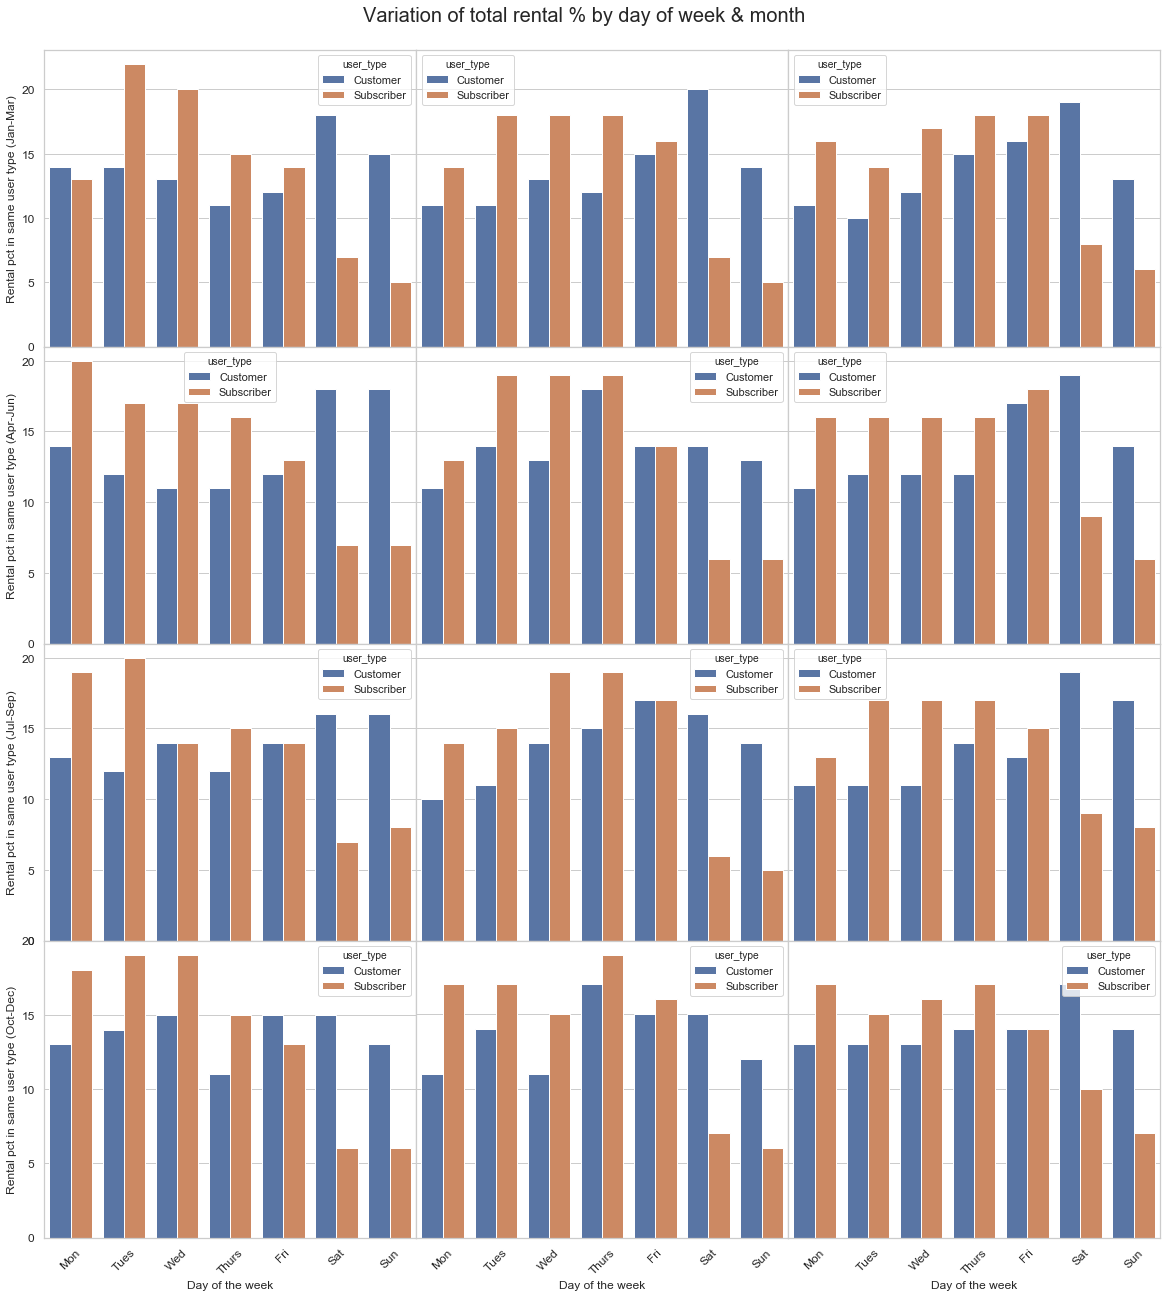

In [103]:
fig, ax = plt.subplots(4, 3, figsize=(20, 20), sharex="col", sharey="row")
fig.suptitle('Variation of total rental % by day of week & month', fontsize=20)
plt.subplots_adjust(wspace=0, hspace=0, top=0.95)
all_months = day_agg_df.end_time_year_month.unique().tolist()
index = 0
g = []
for j in range(len(ax)):
    for i in range(len(ax[j])):
        temp_df = day_agg_df.query("end_time_year_month == '%s'" % all_months[index])
        for item in ([ax[j][i].title, ax[j][i].xaxis.label, ax[j][i].yaxis.label] + ax[j][i].get_xticklabels() + ax[j][i].get_yticklabels()): 
            item.set_fontsize(12)
        g = \
            sns.catplot(
                x="day_of_week", 
                y="pct_of_total", 
                hue="user_type", 
                data=temp_df,  
                kind="bar", 
                ax=ax[j][i]
            )
        g.axes[0][0].set_xlabel('')
        index = index + 1
 
for i in range(2,14):
    plt.close(i)

month_labels = ['Jan-Mar', 'Apr-Jun', 'Jul-Sep', 'Oct-Dec']
index = 0
for j in range(len(ax)):
    for i in range(len(ax[j])):
        if i == 0:
            ax[j][i].set_ylabel('Rental pct in same user type (%s)' % month_labels[index], fontsize=12)
            ax[j][i].set_yticks([0, 5, 10, 15, 20])
            index = index + 1
        else:
            ax[j][i].set_ylabel('')
        if j == len(ax) - 1:
            ax[j][i].set_xlabel('Day of the week', fontsize=12)
            ax[j][i].set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'],rotation=45)
        else:
            ax[j][i].set_xlabel('')

Other than season based variation bike rental business shows periodicity with respect to day of week. Number of rentals are lowest over the weekend - Saturday & Sunday. Monday & Friday are relatively low volume days compared to middle of the week. This brings an interest guess about the purpose of bike rental - whether the main usage is  - pleasure or business use? The fact that the volume of business goes down drastically over the weekend and peaks up steam during middle of the week is indicative that the prime usage is for commuting. In the following section I plan to add another dimension - "hour of day" to perform additional investigation.

### Rental volume by day of week and hour of day<a class="anchor" id="rental_volume_seasonality"></a>

As data shows higher rental volume of weekdays compared to weekend, I would like to additional analysis breaking down the rental volume by days of the hour.  I start aggregating data at hourly granularity and use a line graph as bivariate analysis tool.
While doing the aggregation, I plan to separate out weekdays from weekends so the effect of one doesn't get masked by the other.


In [73]:
# Rental volume aggregation by hour and day type (week day / weekend)
def agg_rental_by_day_type(row):
    return hourly_df.query("is_weekend == %s" % (row['is_weekend']))['rental_count'].sum()

df['is_weekend'] = df.day_of_week.apply(lambda x: True if x in ['Saturday', 'Sunday'] else False)

hourly_df = df.query("end_time_year_month < '2018-03'")[['end_time_hour', 'is_weekend', 'bike_id']]\
.groupby(['end_time_hour', 'is_weekend'])\
.agg({'bike_id': 'count'})\
.reset_index()\
.rename(columns={'bike_id': 'rental_count'})

hourly_df['total_hourly_rental'] = hourly_df.apply(lambda row: agg_rental_by_day_type(row), axis=1)
hourly_df['pct_hourly_rental'] = round(hourly_df.rental_count * 100 / hourly_df.total_hourly_rental, 2)


* Week day rental pattern is very different from week day pattern.
* Week days shows a bimodal distribution with two clear peaks during office commuting hours 7:00 - 10:00 AM and then again in the evening when commuters head out from work between 3:00 PM - 7:30 PM
* Weekend shows business volume increasing smoothly from 9:00 AM till 12 noon and going down from noon time till 8 PM. Most probably these are for pleasure trips to city and surrounding areas.

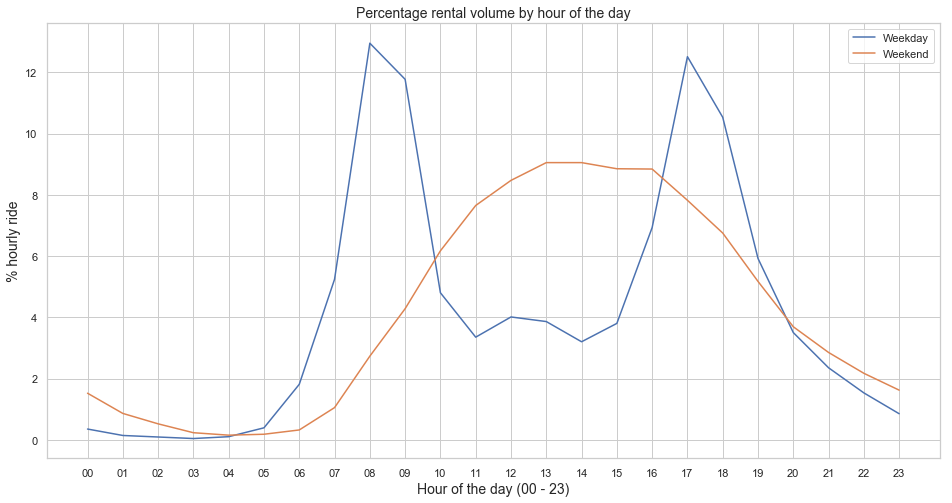

In [74]:
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(data=hourly_df, 
             x='end_time_hour', 
             y='pct_hourly_rental', 
             hue='is_weekend', 
             estimator=None);
ax.set_ylabel('% hourly ride', fontsize=14)
ax.set_title('Percentage rental volume by hour of the day', fontsize=14);
ax.set_xlabel('Hour of the day (00 - 23)', fontsize=14);
ax.legend(['Weekday', 'Weekend']);

In [75]:
# Hourly bike rental volume segmented by gender and age bracket
hourly_df = df.query("end_time_year_month < '2018-03' and member_age_bracket >= '20 - 25' and member_age_bracket <= '30 - 35' and is_weekend == False")\
.query("member_gender == 'Male' or member_gender == 'Female'")[['end_time_hour', 'member_gender', 'member_age_bracket', 'bike_id']]\
.groupby(['end_time_hour', 'member_age_bracket', 'member_gender'])\
.agg({'bike_id': 'count'})\
.reset_index()\
.rename(columns={'bike_id': 'rental_count'})

def agg_rental_by_hour_age(row):
    return hourly_df.query("member_gender == '%s'" % \
                           (row['member_gender']))['rental_count'].sum()
    
hourly_df['total_rental_count'] = hourly_df.apply(lambda x: agg_rental_by_hour_age(x), axis=1)

hourly_df['pct_rental_count'] = hourly_df['rental_count'] * 100 / hourly_df['total_rental_count']

The faceted graph below displays % of total rental percentage segmented by hour of the day, age bracket & gender. Three groups chosen to be plotted are 20-25, 25-30 & 30-35. These are the three most active age groups within both genders.

Rental pattern by male bikers is same as their female counterparts. But relatively higher percentage of female bikers tend to reach their destination by 8:00 AM. 

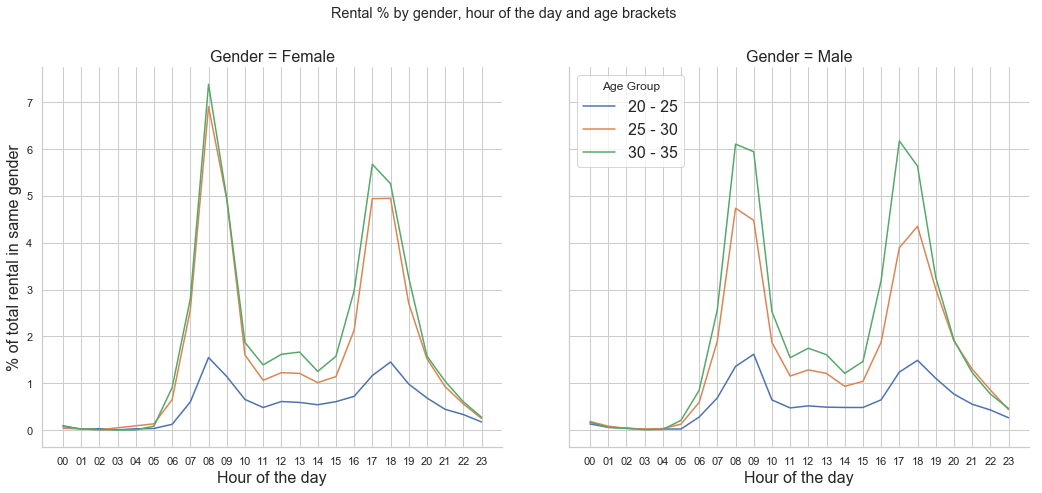

In [76]:
g = sns.FacetGrid(hourly_df, col="member_gender", hue='member_age_bracket')
g.map(sns.lineplot, 'end_time_hour','pct_rental_count', estimator=None, legend='full')
plt.gcf().set_size_inches(16, 8)
plt.legend(title='Age Group', fontsize=16)
g.axes[0][0].set_ylabel('% of total rental in same gender', size=16)
g.axes[0][0].set_xlabel('Hour of the day', size=16)
g.axes[0][1].set_xlabel('Hour of the day', size=16)
g.axes[0][0].set_title('Gender = Female', size=16)
g.axes[0][1].set_title('Gender = Male', size=16);
plt.suptitle("Rental % by gender, hour of the day and age brackets");

The faceted graph above displays total rental percentage segmented by hour of the day. Additional dimensions are gender and age bracket. Within each graph, I have chosen 3 age groups to be plotted 20-25, 25-30 & 30-35. These are the three most active age groups within both genders.

* Rental pattern by male bikers follows similar pattern as female counterparts.
* Relatively higher percentage of female bikers tend to reach their destination by 8:00 AM. This indicated by the sharp peak in the graph on left hand side.

To highlight this trend, I have combined male & female bikers in age group '30 - 35' into a single multi-line graph.

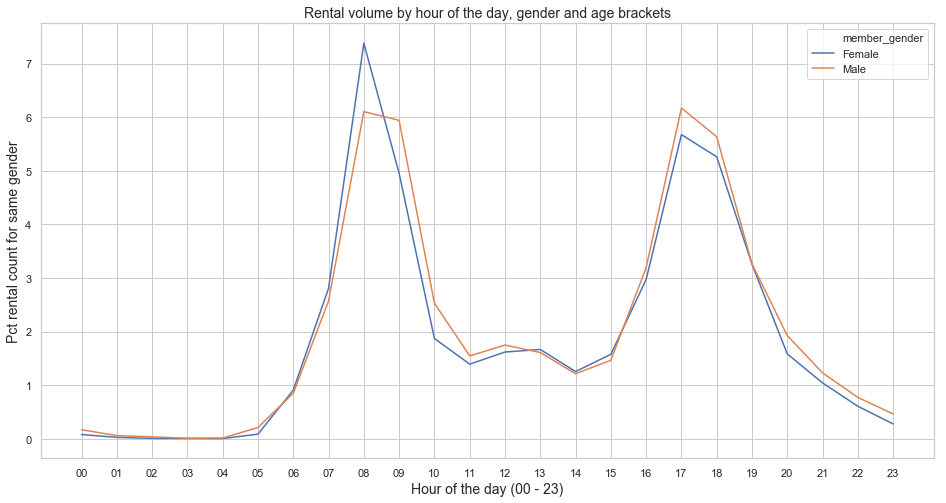

In [77]:
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(data=hourly_df.query("member_age_bracket == '30 - 35'"), 
             x='end_time_hour', 
             y='pct_rental_count', 
             hue='member_gender', 
             estimator=None);
ax.set_ylabel('Pct rental count for same gender', fontsize=14)
ax.set_title('Rental volume by hour of the day, gender and age brackets', fontsize=14);
ax.set_xlabel('Hour of the day (00 - 23)', fontsize=14);

Next percentage rental volume of two user types are combined with the day of the week dimension with hour of the day in several heat maps.

In [78]:
median_rental_df = \
df.query("member_age_bracket >= '20 - 25' and member_age_bracket <= '35 - 40'")\
.query("member_gender == 'Male' or member_gender == 'Female'")\
.groupby(['member_gender', 'user_type', 'end_time_hour', 'day_of_week', 'end_date'])\
.agg({'bike_id': 'count'})\
.reset_index()\
.rename(columns={'bike_id': 'rental_count'})

median_rental_df = \
median_rental_df.groupby(['member_gender', 'user_type', 'end_time_hour', 'day_of_week'])\
.agg({'rental_count': 'median'})\
.reset_index()\
.rename(columns={'rental_count': 'median_rental_count'})

median_rental_df['median_rental_count'] = median_rental_df['median_rental_count'].astype('int')

day_hour_rental_df = \
median_rental_df.pivot_table(
    index=['end_time_hour','member_gender', 'user_type'], 
    columns='day_of_week', 
    values='median_rental_count', 
    fill_value = 0)\
.reset_index()[['end_time_hour', 'member_gender', 'user_type', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]
 
day_hour_rental_df['user'] = day_hour_rental_df.apply(lambda row: row['member_gender'] + ' ' + row['user_type'], axis=1)




Following group of four heat maps are corresponding 4 user segments - female customer, female subscriber, male customer & male subscriber. The annotations in the heat map show the median value of the bike rental count for age groups between 20 - 40 years. 

Rental pattern shows non-subscribers are primarily using the rental during the weekend and subscribers are using it during regular commute hours between Monday through Friday.

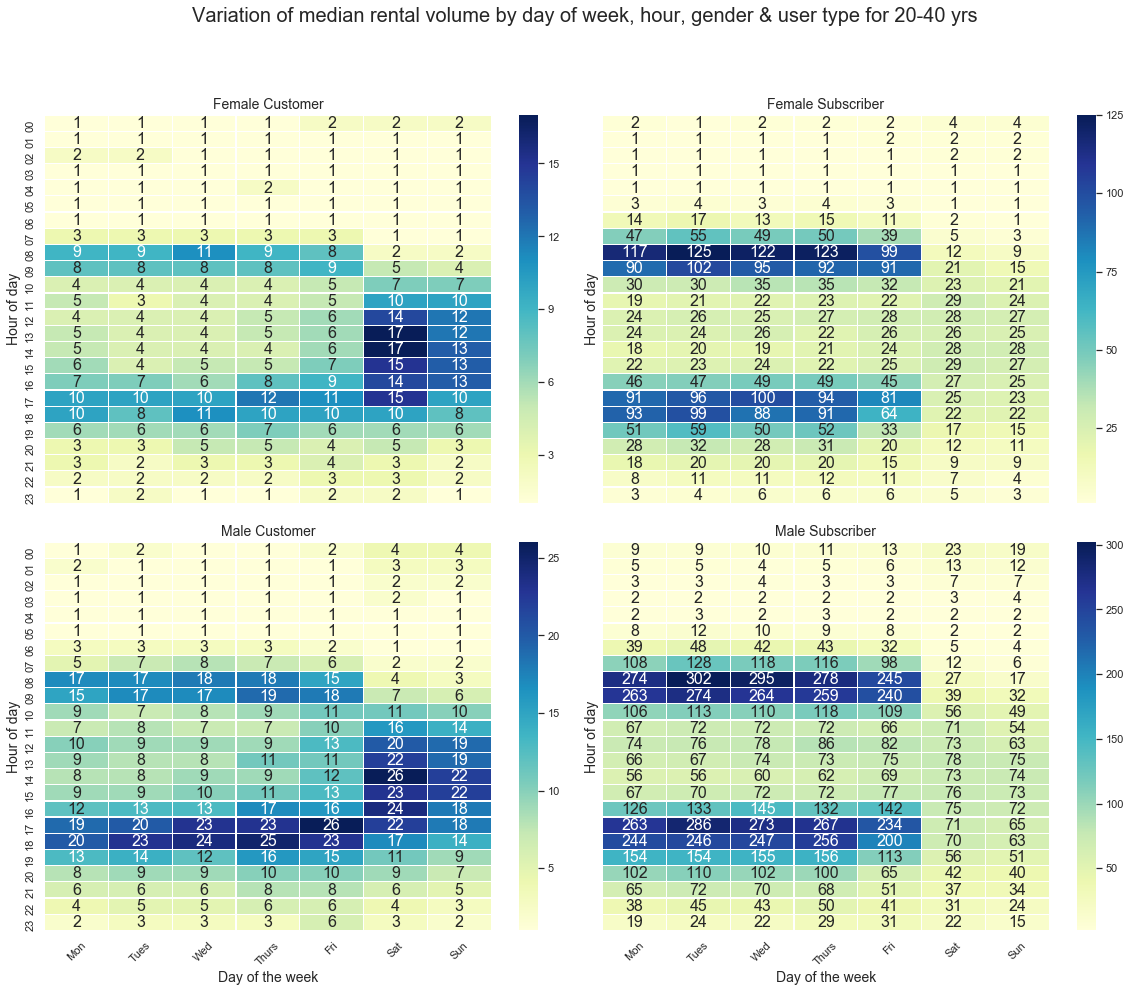

In [79]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15), sharex="col", sharey="row")
fig.suptitle('Variation of median rental volume by day of week, hour, gender & user type for 20-40 yrs', fontsize=20)
user = day_hour_rental_df.user.unique().tolist()
plt.subplots_adjust(wspace=0, hspace=.1)
index = 0
for j in range(len(ax)):
    for i in range(len(ax[j])):
        temp_df = day_hour_rental_df.query("user == '%s'" % user[index])[['end_time_hour', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]
        temp_df = temp_df.set_index('end_time_hour')
        index = index + 1
        g = sns.heatmap(temp_df, annot=True, fmt="d", linewidths=.2, cmap="YlGnBu", annot_kws={"size":16}, ax=ax[j][i]);
        
index = 0
for j in range(len(ax)):
    for i in range(len(ax[j])):
        ax[j][i].set_ylabel('Hour of day', fontsize=14)
        ax[j][i].set_title('%s' % user[index], fontsize=14)
        index = index + 1
        if j == len(ax) - 1:
            ax[j][i].set_xlabel('Day of the week', fontsize=14)
            ax[j][i].set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'],rotation=45)
        else:
            ax[j][i].set_xlabel('')



### San Francisco Weather<a class="anchor" id="san_francisco_weather"></a>

Earlier I noted that monthly rental volume shows seasonal pattern. To prove the influence of precipatation I have imported additional dataset.

I have downloaded daily precipitation data for San Francisco city from https://www.ncdc.noaa.gov/cdo-web/

Once the request is submitted to NOAA website, csv file is emailed to the provided email address. The structure of the file is as follows

1. DAPR - Number of days included in the multiday precipitation total (MDPR)
2. SNOW - Snowfall
3. TMAX - Maximum temperature (in Farenhiet
4. TAVG - Average Temperature.
5. TMIN - Minimum temperature
6. PRCP - Precipitation (in inches)
7. TOBS - Temperature at the time of observation
8. MDPR - Multiday precipitation total (use with DAPR and DWPR, if available)
9. SNWD - Snow depth

From the above file, I will utilize date & daily preciptation (PRCP) and plot it in a dual axis graph along with daily rental count.




In [80]:
sf_weather_df = pd.read_csv("data/SF_Weather.csv")
sf_weather_df = sf_weather_df[sf_weather_df.NAME.str.startswith('SAN FRANCISCO DOWNTOWN')][['NAME', 'DATE', 'PRCP', 'TMIN', 'TMAX']]


/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [81]:
daily_agg_df = df[['end_date', 'day_of_week', 'bike_id']]\
.groupby(['end_date', 'day_of_week'], as_index=False)\
.agg({'bike_id': 'count'})\
.rename(columns={'bike_id': 'rental_count'})

merged_df = pd.merge(daily_agg_df, sf_weather_df, left_on='end_date', right_on='DATE')[['end_date', 'day_of_week', 'PRCP', 'TMIN', 'TMAX', 'rental_count']]\
.rename(columns={'PRCP': 'precipitation', 'TMIN': 'min_temp', 'TMAX': 'max_temp'})



In [82]:
"""
Generic routine to plot dual y-axis line graph
Input parameters:
  df: dataframe containing bike rental count & precipitation data
  start_date: Period starting date in the format YYYY-MM-DD
  end_date: Period end date in . the format YYYY-MM-DD
"""
def plot_monthly_rental(df, start_date, end_date):
    daily_df = df.query("end_date >= '%s' and end_date <= '%s'" % (start_date, end_date))
    fig, ax = plt.subplots(figsize=(16,8))
    line1 = ax.plot(daily_df.end_date, daily_df.rental_count, c='b', alpha=0.8)
    ax.set_title('Daily bike rental count and rainfall (in inches) in San Francisco city for period: %s to %s' % (start_date, end_date), fontsize=14)
    ax.set_xlabel('Rental Date', fontsize=14)
    ax.set_ylabel('Rental count',fontsize=14) 

    ax2 = ax.twinx()
    line2 = ax2.plot(daily_df.end_date, daily_df.precipitation, c='g', alpha=0.8)
    ax2.set_ylabel('Precipitation (inches)',fontsize=14);
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    plt.legend(h1 + h2, ['rental count', 'precipitation'], loc=1);

    x_ticks = daily_df.query("day_of_week == 'Sunday'").end_date
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_ticks, rotation=45);
    ax.grid(b=True, alpha=0.4)
    
    
    

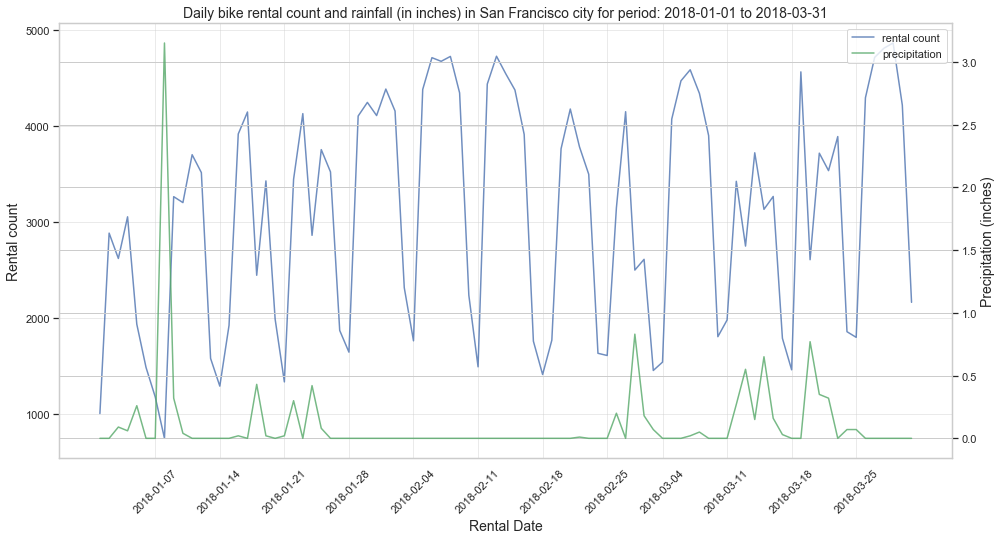

In [83]:
# Daily bike rental count & preciptation number for Jan 2018 to Mar 2018
plot_monthly_rental(merged_df, '2018-01-01', '2018-03-31')

    

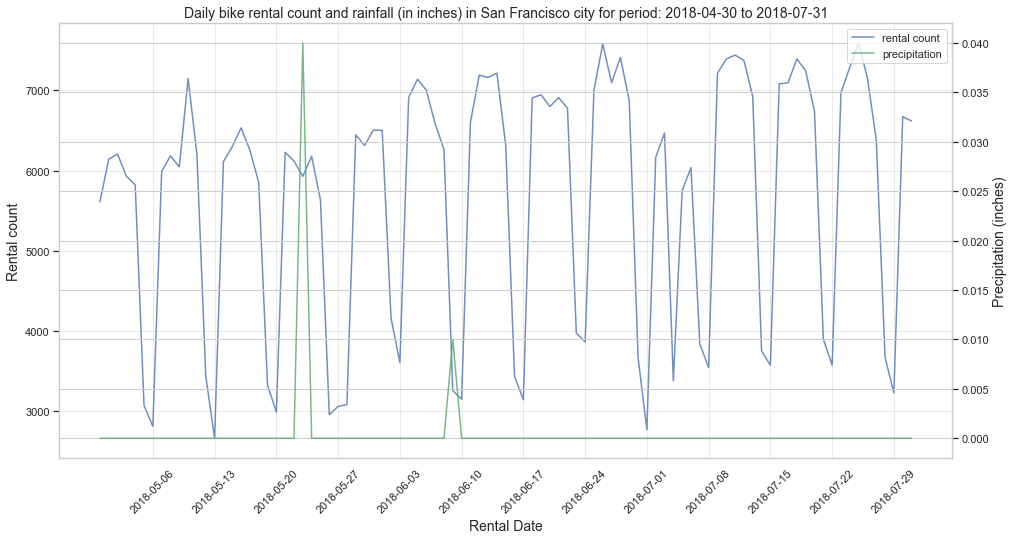

In [84]:
# Daily bike rental count & preciptation number for Apr 2018 to Jul 2018
plot_monthly_rental(merged_df, '2018-04-30', '2018-07-31')


<font color=blue>
<ol>
<li>Daily precipitation data from NOAA has been plotted along with daily bike rental volume in the dual axis graph</li>
<li>With barely no rain happening between the months of May through October, rental volume follows the weekly cyclical pattern. Only a day of rain in the first week October didn't have any impact as amount of precipitation is only 0.2 inch</li>
</ol>
</font>

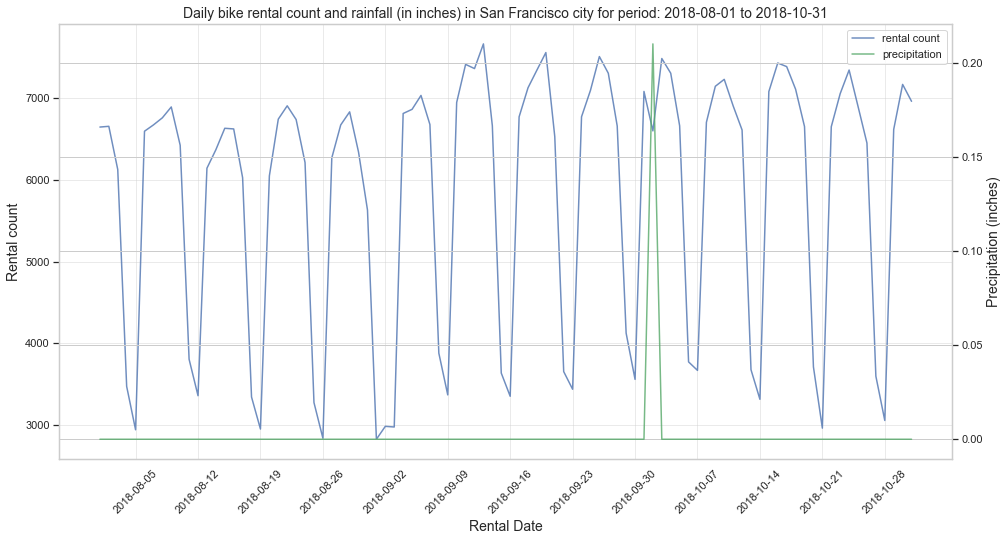

In [85]:
# Daily bike rental count & preciptation number for Aug 2018 to Oct 2018
plot_monthly_rental(merged_df, '2018-08-01', '2018-10-31')

<font color=blue>Rain in November and December impacts the business. Every of precipitation can be tied to a dip in bike rental</font>

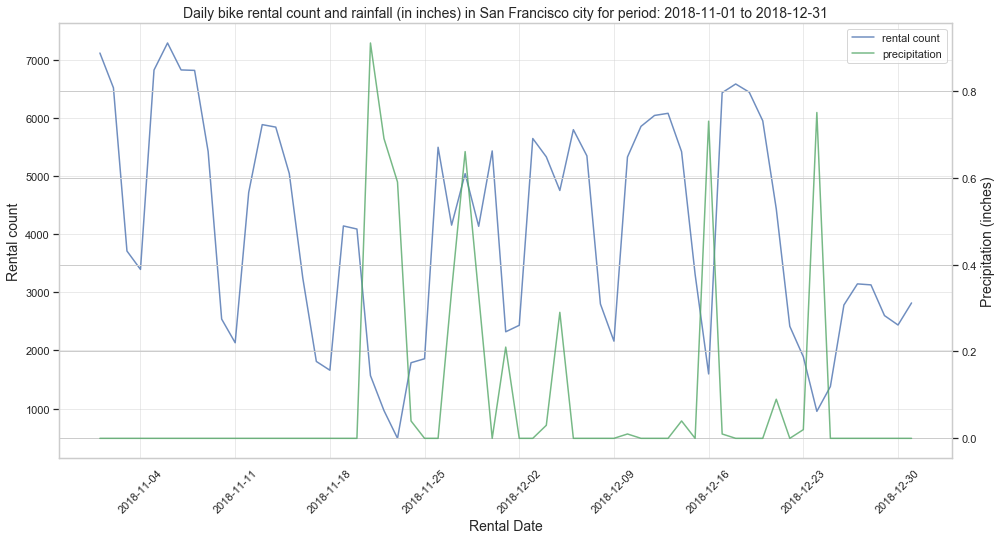

In [86]:
# Daily bike rental count & preciptation number for Nov 2018 to Dec 2018
plot_monthly_rental(merged_df, '2018-11-01', '2018-12-31')

**Observations from the above time series**

1. Most of the precipitation in San Francisco happens during winter months Nov - Jan. Every high precipitation can be tied a significant dip in bike rental.
2. Reduced bike rental because of high precipitation is obserable even on weekdays.

